# Credit card consumption

## Business problem

Some customers are having missing values for credit consumption. We need to build the model using customer’s data where credit consumption is non- missing. You need to predict the credit consumption for next three months for the customers having missing
values.

In [1]:
# Importing libraries for EDA, cleaning and preprocessing
import numpy as np
import pandas as pd
import datetime as dt

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from ydata_profiling import ProfileReport

In [2]:
# Machine learning packages
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf # Optimization of straight line
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF Selection
from patsy import dmatrices # Dependency for VIF

In [3]:
# pip install xgboost

In [173]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [5]:
# grid seach cv
from sklearn.model_selection import GridSearchCV

## Importing data

We are given 3 worksheets in excel formats.
We are importing the data in python and we will join the tables.

In [267]:
file_location = 'C://Projects_python//Project_machinelearning//CaseStudy//Input//11. Capstone Case Study - Predict Cred Card Consumption//'
file_name = 'CreditConsumptionData.xlsx'
CreditConsumptionData = pd.read_excel(file_location+file_name)
file_name = 'CustomerBehaviorData.xlsx'
CustomerBehaviorData = pd.read_excel(file_location+file_name)
file_name = 'CustomerDemographics.xlsx'
CustomerDemographics = pd.read_excel(file_location+file_name)

In [268]:
CreditConsumptionData.head()

ID  cc_cons
0  12554  20014.0
1  17645  10173.0
2   7604  16095.0
3   1590   7707.0
4  16556  96408.0

This table contains 
ID that is customer ID column which is primary key.
cc_cons column gives average Credit Card Spend in next three months. This is our target variable(y) 

In [269]:
CustomerBehaviorData.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  \
0       6693.0          19.0            10             2  ...   
1       6117.0           4.0            60             1  ...   
2       2638.0           2.0            83            47  ...   
3       3711.0          12.0             2            16  ...   
4       1065.0          15.0            13            61  ...   

   credit_count_may  debit_count_may  max_credit_amount_may  debit_amount_jun  \
0                 1              108                97916.0          45253.64   
1                 1                4                25125.0          12912.33   
2                70               11                38546.0          93567.51   
3                43                1               180315.0         176394.48   
4                 2               14                13480.0           3167.00   

   credit_amount_jun  credit_count_jun  debit_count_jun  \
0           47635.00                 2               18   
1           18369.00                 3               49   
2           26713.00                47               49   
3           35062.74                 3               37   
4           19056.00                 2               15   

   max_credit_amount_jun  loan_enq  emi_active  
0                19947.0         Y     3448.84  
1                20585.0         Y     3812.69  
2                13950.0         Y     9432.90  
3                37018.0         Y      144.61  
4                24274.0         Y     1887.89  

[5 rows x 39 columns]

This table contains
customer id which is unique key
debit card and credit card consumption, total transactions for the different months of apr, may and june.
It also contains maximum credit card limit. 
For each costomers various loan information is also provided of past 12 months eg. having personal loan, vehicle loan etc.
This table gives the 4 types of investment done by the customer.
It also gives informaion of the amount credit or debit. Along with the number of times the amount was credit or debit in a month and the maximum amount that was credit.
It gives the imformaion on loan enquiry was there or not.
It gives information about the EMI's paid to other banks or not.

In [270]:
CustomerDemographics.head()

ID account_type gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0  19427      current      M   63  MEDIUM              30.1                10   
1  16150      current      M   36  MEDIUM              14.4                10   
2  11749      current      F   28  MEDIUM               4.8                10   
3  11635      current      M   32  MEDIUM               9.6                 2   
4   8908      current      M   32    HIGH              12.0                 7   

   region_code  NetBanking_Flag  Avg_days_between_transaction  
0        628.0                1                           5.0  
1        656.0                0                          12.0  
2        314.0                1                          13.0  
3        614.0                1                          19.0  
4        750.0                1                          18.0

This table gives demographic information like account type, gender, age, income level, enployement tenure,number of years with bank, region code, use netbanking or not and average days between the transactions.

In [271]:
# merging the tables
df1 = pd.merge(left= CustomerBehaviorData, right= CustomerDemographics, left_on='ID', right_on='ID', how= 'inner')
df1.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  emi_active  \
0       6693.0          19.0            10             2  ...     3448.84   
1       6117.0           4.0            60             1  ...     3812.69   
2       2638.0           2.0            83            47  ...     9432.90   
3       3711.0          12.0             2            16  ...      144.61   
4       1065.0          15.0            13            61  ...     1887.89   

   account_type  gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
0       current       M   30  MEDIUM               7.0                 5   
1       current       M   37     LOW              10.2                 8   
2       current       M   33  MEDIUM               3.9                 3   
3       current       M   63     LOW              25.8                 6   
4        saving       M   33  MEDIUM               6.5                 7   

   region_code  NetBanking_Flag  Avg_days_between_transaction  
0        956.0                1                          20.0  
1        966.0                1                           5.0  
2        505.0                1                          15.0  
3        631.0                0                          15.0  
4        698.0                0                           9.0  

[5 rows x 48 columns]

In [272]:
# final data
df = pd.merge(left= df1, right= CreditConsumptionData, left_on= 'ID', right_on= 'ID', how= 'inner')

## Data Audit

In [273]:
CreditConsumptionData.shape

(20000, 2)

In [274]:
CustomerDemographics.shape

(20000, 10)

In [275]:
df.shape

(20000, 49)

In the final dataset we have 20,000 rows and 49 columns of data.

We will only deal with df(final dataet) for further analysis.

In [276]:
# checking the missing data in the data
df.isnull().sum()

ID                                 0
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        1
dc_cons_may                        0
cc_cons_jun                        0
dc_cons_jun                        1
cc_count_apr                       1
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
personal_loan_active               0
vehicle_loan_active                0
personal_loan_closed               1
vehicle_loan_closed                0
investment_1                       0
investment_2                       0
investment_3                       2
investment_4                       0
debit_amount_apr                   0
credit_amount_apr                  0
debit_count_apr                    1
credit_count_apr                   0
max_credit_amount_apr              0
d

In [277]:
# 5000 is subtracted because these values we need to keep and predict the values for them.
(df.isnull().sum().sum()-5000)/20000*100

0.08499999999999999

we have 20000 rows of data out of which <1% data is missing. So, we can drop these values.

In [278]:
# Separating the unknown target variables from the dataset
df1 = df.loc[df.cc_cons.isna()]

In [279]:
df1.shape

(5000, 49)

In [280]:
df1.isnull().sum()

ID                                 0
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        1
dc_cons_may                        0
cc_cons_jun                        0
dc_cons_jun                        1
cc_count_apr                       0
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
personal_loan_active               0
vehicle_loan_active                0
personal_loan_closed               0
vehicle_loan_closed                0
investment_1                       0
investment_2                       0
investment_3                       0
investment_4                       0
debit_amount_apr                   0
credit_amount_apr                  0
debit_count_apr                    0
credit_count_apr                   0
max_credit_amount_apr              0
d

In [281]:
# Dropping cc_cons column which we have to predict
df1.drop(columns= 'cc_cons', inplace= True)

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\3954761421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns= 'cc_cons', inplace= True)


In [282]:
# checking the null values in ithe unseen data.
df1.isnull().sum().sum()

8

In [283]:
# Removing these null values
df1.dropna(inplace= True)

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\2319900812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace= True)


In [284]:
df1.isnull().sum()

ID                              0
cc_cons_apr                     0
dc_cons_apr                     0
cc_cons_may                     0
dc_cons_may                     0
cc_cons_jun                     0
dc_cons_jun                     0
cc_count_apr                    0
cc_count_may                    0
cc_count_jun                    0
dc_count_apr                    0
dc_count_may                    0
dc_count_jun                    0
card_lim                        0
personal_loan_active            0
vehicle_loan_active             0
personal_loan_closed            0
vehicle_loan_closed             0
investment_1                    0
investment_2                    0
investment_3                    0
investment_4                    0
debit_amount_apr                0
credit_amount_apr               0
debit_count_apr                 0
credit_count_apr                0
max_credit_amount_apr           0
debit_amount_may                0
credit_amount_may               0
credit_count_m

This dataset will be used once we make a good regression model.

In [285]:
# traing data
df.shape

(20000, 49)

In [286]:
# preparing the training data
df.dropna(inplace= True)
df.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  account_type  \
0       6693.0          19.0            10             2  ...       current   
1       6117.0           4.0            60             1  ...       current   
2       2638.0           2.0            83            47  ...       current   
3       3711.0          12.0             2            16  ...       current   
4       1065.0          15.0            13            61  ...        saving   

   gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  region_code  \
0       M   30  MEDIUM               7.0                 5        956.0   
1       M   37     LOW              10.2                 8        966.0   
2       M   33  MEDIUM               3.9                 3        505.0   
3       M   63     LOW              25.8                 6        631.0   
4       M   33  MEDIUM               6.5                 7        698.0   

   NetBanking_Flag  Avg_days_between_transaction  cc_cons  
0                1                          20.0  13434.0  
1                1                           5.0    449.0  
2                1                          15.0  11968.0  
3                0                          15.0  32029.0  
4                0                           9.0  16394.0  

[5 rows x 49 columns]

On this data we will train the model

## Exploratory Data Analysis

In [287]:
df.dtypes

ID                                int64
cc_cons_apr                     float64
dc_cons_apr                     float64
cc_cons_may                     float64
dc_cons_may                     float64
cc_cons_jun                     float64
dc_cons_jun                     float64
cc_count_apr                    float64
cc_count_may                      int64
cc_count_jun                      int64
dc_count_apr                      int64
dc_count_may                      int64
dc_count_jun                      int64
card_lim                          int64
personal_loan_active              int64
vehicle_loan_active               int64
personal_loan_closed            float64
vehicle_loan_closed               int64
investment_1                    float64
investment_2                    float64
investment_3                    float64
investment_4                    float64
debit_amount_apr                float64
credit_amount_apr               float64
debit_count_apr                 float64


taking care of categorical variables

In [288]:
df.loan_enq.value_counts()

Y    14995
Name: loan_enq, dtype: int64

Since we don't need this loan enqpuery column as all the values are 'Y' we will drop this colummn

In [289]:
df.drop(columns= 'loan_enq', inplace= True)

In [290]:
# Similarly we will drop the columnin the unseen data
df1.drop(columns= 'loan_enq', inplace= True)

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\69155553.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns= 'loan_enq', inplace= True)


In [291]:
# account type column
df.account_type.value_counts()

current    12722
saving      2273
Name: account_type, dtype: int64

In [292]:
# Here, we have 2 types of account and we can substitute 0 and 1 for this.

In [293]:
df.account_type = np.where(df.account_type == 'current',1,0)

In [294]:
df.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  account_type  \
0       6693.0          19.0            10             2  ...             1   
1       6117.0           4.0            60             1  ...             1   
2       2638.0           2.0            83            47  ...             1   
3       3711.0          12.0             2            16  ...             1   
4       1065.0          15.0            13            61  ...             0   

   gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  region_code  \
0       M   30  MEDIUM               7.0                 5        956.0   
1       M   37     LOW              10.2                 8        966.0   
2       M   33  MEDIUM               3.9                 3        505.0   
3       M   63     LOW              25.8                 6        631.0   
4       M   33  MEDIUM               6.5                 7        698.0   

   NetBanking_Flag  Avg_days_between_transaction  cc_cons  
0                1                          20.0  13434.0  
1                1                           5.0    449.0  
2                1                          15.0  11968.0  
3                0                          15.0  32029.0  
4                0                           9.0  16394.0  

[5 rows x 48 columns]

the account type column is corrected with the numerical values of 0 and 1. where 1 represents current account and 0 represents saving account.

In [295]:
df.gender.value_counts()

M    12941
F     2054
Name: gender, dtype: int64

in gender columnn also we need to replace the value of M and F with numerical values.

In [296]:
df.gender = np.where(df.gender == 'M',1,0)

In [297]:
df.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0  17051      3412.60      2909.34      1077.36      3084.50      4615.97   
1  11491     18133.76      3877.00      6123.78      5597.43     64620.00   
2   7433      6363.65       735.49      8799.00     13768.00     38266.00   
3  14606     12765.66      4429.16     16745.86      6360.00     29063.97   
4   8381     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  account_type  \
0       6693.0          19.0            10             2  ...             1   
1       6117.0           4.0            60             1  ...             1   
2       2638.0           2.0            83            47  ...             1   
3       3711.0          12.0             2            16  ...             1   
4       1065.0          15.0            13            61  ...             0   

   gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  region_code  \
0       1   30  MEDIUM               7.0                 5        956.0   
1       1   37     LOW              10.2                 8        966.0   
2       1   33  MEDIUM               3.9                 3        505.0   
3       1   63     LOW              25.8                 6        631.0   
4       1   33  MEDIUM               6.5                 7        698.0   

   NetBanking_Flag  Avg_days_between_transaction  cc_cons  
0                1                          20.0  13434.0  
1                1                           5.0    449.0  
2                1                          15.0  11968.0  
3                0                          15.0  32029.0  
4                0                           9.0  16394.0  

[5 rows x 48 columns]

we need to deal with tthe Income column. we need to replace them with numerical values.

In [298]:
df.Income.value_counts()

MEDIUM    9610
LOW       4186
HIGH      1199
Name: Income, dtype: int64

In [299]:
df.Income = np.where(df.Income == 'LOW',1,np.where(df.Income == 'MEDIUM',2,3))

In [300]:
df.Income.value_counts()

2    9610
1    4186
3    1199
Name: Income, dtype: int64

In [301]:
# we have changed the income column into numerical. we replaced low low with 1, medium with 2 and high with 3.

In [302]:
# doing the same data manipulation for df1 dataset sice, they need to be in the same format
df1.account_type = np.where(df1.account_type == 'current',1,0)
df1.gender = np.where(df1.gender == 'M',1,0)
df1.Income = np.where(df1.Income == 'LOW',1,np.where(df1.Income == 'MEDIUM',2,3))

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\1874470875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.account_type = np.where(df1.account_type == 'current',1,0)
C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\1874470875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.gender = np.where(df1.gender == 'M',1,0)
C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\1874470875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [303]:
df1.head()

ID  cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
15000  17591      2795.45       1290.0      6141.05       676.50      9146.10   
15001  13541     29405.13       1640.0      1670.00      2463.92     10947.50   
15002  13431      5985.20       6189.0      2696.09       766.00       716.00   
15003   8687      2105.93      18225.0     34763.56       167.00      4260.27   
15004  14727      3269.00       3532.0      3158.40      2699.77      3373.48   

       dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  ...  emi_active  \
15000     15479.00           4.0            10             4  ...     1170.49   
15001       956.00           3.0            10             4  ...    16447.45   
15002      4133.22           7.0            30             5  ...     2622.28   
15003     20185.00           1.0            99            71  ...      340.79   
15004      5120.00           2.0            10            47  ...     2812.20   

       account_type  gender  age  Income  Emp_Tenure_Years  Tenure_with_Bank  \
15000             1       1   37       2              11.9                 4   
15001             1       1   33       2               7.8                 6   
15002             1       1   53       1              33.0                10   
15003             1       1   33       2               7.8                 5   
15004             1       1   62       1              12.6                 9   

       region_code  NetBanking_Flag  Avg_days_between_transaction  
15000        575.0                1                          16.0  
15001        394.0                0                          19.0  
15002        324.0                1                          15.0  
15003        370.0                1                           7.0  
15004        505.0                1                           3.0  

[5 rows x 47 columns]

This dataset is now changed as per our encoding. It is not changed by operations like outlier treatment etc. It needs to get predicted and solemnly kept for that purpose. We will change only df dataframe for training purpose.

In [304]:
df.describe(percentiles= np.arange(0, 100, 5)/100)

ID    cc_cons_apr    dc_cons_apr   cc_cons_may  \
count  14995.000000   14995.000000   14995.000000  1.499500e+04   
mean   10032.128443   17960.830861    8171.498747  1.633869e+04   
std     5760.865867   25191.316571   14775.132716  2.706498e+04   
min        1.000000     253.000000      19.350000  1.570000e+02   
0%         1.000000     253.000000      19.350000  1.570000e+02   
5%      1043.700000    1239.400000     376.000000  1.043040e+03   
10%     2055.400000    1918.970000     656.000000  1.677000e+03   
15%     3053.100000    2747.250000     950.000000  2.322107e+03   
20%     4067.800000    3611.484000    1285.000000  2.958440e+03   
25%     5058.500000    4411.590000    1634.000000  3.638000e+03   
30%     6052.200000    5319.000000    2008.752000  4.473700e+03   
35%     7043.900000    6304.280000    2407.600000  5.275042e+03   
40%     8042.600000    7476.000000    2915.000000  6.245130e+03   
45%     9040.900000    8857.175000    3444.370000  7.252240e+03   
50%    10055.000000   10288.100000    3994.800000  8.694000e+03   
55%    11012.700000   11896.660000    4704.000000  1.000743e+04   
60%    12005.400000   13513.600000    5431.860000  1.180600e+04   
65%    12992.100000   15708.620000    6348.700000  1.380735e+04   
70%    13998.600000   18289.160000    7714.400000  1.615847e+04   
75%    15015.500000   21407.625000    9339.020000  1.895130e+04   
80%    16025.200000   25684.000000   11035.208000  2.307320e+04   
85%    17031.900000   31661.680000   14015.400000  2.836991e+04   
90%    18028.600000   41017.086000   18439.052000  3.629936e+04   
95%    19003.300000   60198.734000   27835.000000  5.495978e+04   
max    19998.000000  441031.330000  229255.000000  1.117246e+06   

         dc_cons_may    cc_cons_jun    dc_cons_jun  cc_count_apr  \
count   14995.000000   14995.000000   14995.000000  14995.000000   
mean     7702.797188   12130.345532    7098.205684     41.492631   
std     18988.978011   18491.403327   13253.768400     97.447505   
min        22.000000      65.000000      62.000000      1.000000   
0%         22.000000      65.000000      62.000000      1.000000   
5%        410.820000     833.000000     389.000000      1.000000   
10%       742.200000    1377.200000     603.640000      2.000000   
15%      1014.000000    1938.004000     816.000000      3.000000   
20%      1332.850000    2493.000000    1050.016000      4.000000   
25%      1643.500000    3004.500000    1358.000000      5.000000   
30%      2012.000000    3587.000000    1702.000000      6.000000   
35%      2356.806000    4242.096000    2027.000000      6.000000   
40%      2798.820000    4952.000000    2440.460000      7.000000   
45%      3339.250000    5734.000000    2885.562000      8.000000   
50%      3821.000000    6655.250000    3327.000000     10.000000   
55%      4379.000000    7669.850000    3801.637000     12.000000   
60%      5082.400000    8768.294000    4514.000000     17.000000   
65%      5895.100000   10263.000000    5257.100000     24.000000   
70%      6847.000000   12051.600000    6306.000000     26.000000   
75%      8212.000000   14247.000000    7597.000000     44.000000   
80%      9962.000000   16785.540000    9270.000000     52.000000   
85%     12289.000000   20960.800000   11734.350000     60.000000   
90%     16077.960000   27043.490000   15856.000000     80.000000   
95%     25430.894000   40127.367000   24148.830000    124.000000   
max    911223.490000  382914.100000  233384.000000    531.000000   

       cc_count_may  cc_count_jun  ...  account_type        gender  \
count  14995.000000  14995.000000  ...  14995.000000  14995.000000   
mean      33.488296     41.496699  ...      0.848416      0.863021   
std       49.547493     47.347292  ...      0.358629      0.343837   
min        1.000000      1.000000  ...      0.000000      0.000000   
0%         1.000000      1.000000  ...      0.000000      0.000000   
5%         2.000000      3.000000  ...      0.000000      0.000000   
10%        3.00

1. ID is taken for the description purpose only, This cannot be used for the operations like percentile, std sev etc.
2. There are many outliers in the datast for the cc_cons and dc_cons for different months we need to take care of them before training the model.

In [305]:
df.region_code.value_counts().count()

210

In [306]:
# we have 210 regions in total where the customers are comming from.
# we dont need them as numerical. They cannot be used for any arithmatic operation.

In [307]:
df.drop(columns= ['ID', 'region_code'], inplace= True)
df1.drop(columns= ['ID', 'region_code'], inplace= True)

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\346464939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns= ['ID', 'region_code'], inplace= True)


In [308]:
# plotting the box-plots for knowing the outliers

In [309]:
df.columns

Index(['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'vehicle_loan_active',
       'personal_loan_closed', 'vehicle_loan_closed', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'emi_active',
       'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years',
       'Tenure_with_Bank', 'NetBanking_Flag', 'Avg_days_between_transaction',
       'cc_cons'],
      dtype='object')

In [310]:
column_names = ['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'vehicle_loan_active',
       'personal_loan_closed', 'vehicle_loan_closed', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'emi_active',
       'account_type', 'age', 'Income', 'Emp_Tenure_Years',
       'Tenure_with_Bank', 'NetBanking_Flag', 'Avg_days_between_transaction']

In [311]:
column_names

['cc_cons_apr',
 'dc_cons_apr',
 'cc_cons_may',
 'dc_cons_may',
 'cc_cons_jun',
 'dc_cons_jun',
 'cc_count_apr',
 'cc_count_may',
 'cc_count_jun',
 'dc_count_apr',
 'dc_count_may',
 'dc_count_jun',
 'card_lim',
 'personal_loan_active',
 'vehicle_loan_active',
 'personal_loan_closed',
 'vehicle_loan_closed',
 'investment_1',
 'investment_2',
 'investment_3',
 'investment_4',
 'debit_amount_apr',
 'credit_amount_apr',
 'debit_count_apr',
 'credit_count_apr',
 'max_credit_amount_apr',
 'debit_amount_may',
 'credit_amount_may',
 'credit_count_may',
 'debit_count_may',
 'max_credit_amount_may',
 'debit_amount_jun',
 'credit_amount_jun',
 'credit_count_jun',
 'debit_count_jun',
 'max_credit_amount_jun',
 'emi_active',
 'account_type',
 'age',
 'Income',
 'Emp_Tenure_Years',
 'Tenure_with_Bank',
 'NetBanking_Flag',
 'Avg_days_between_transaction']

## Univariate Analysis

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


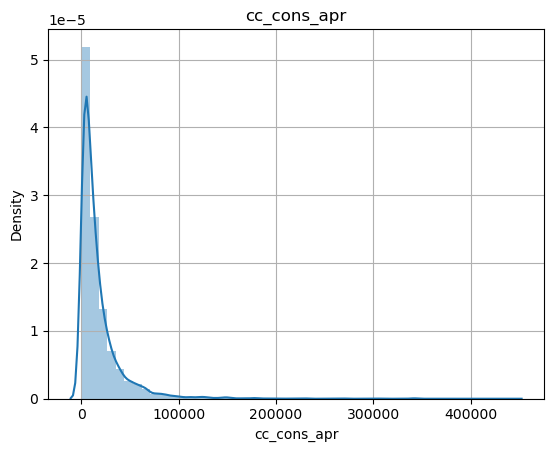

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


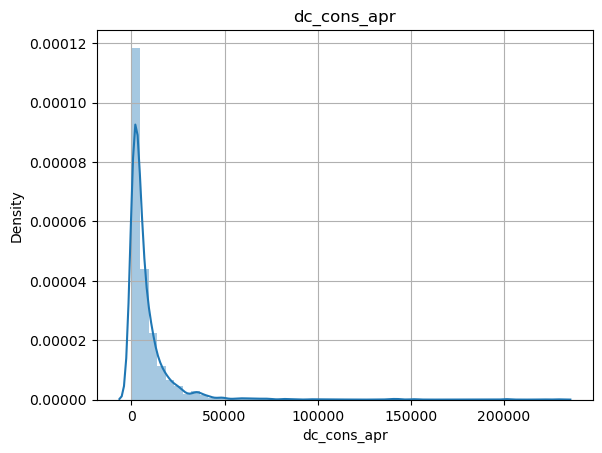

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


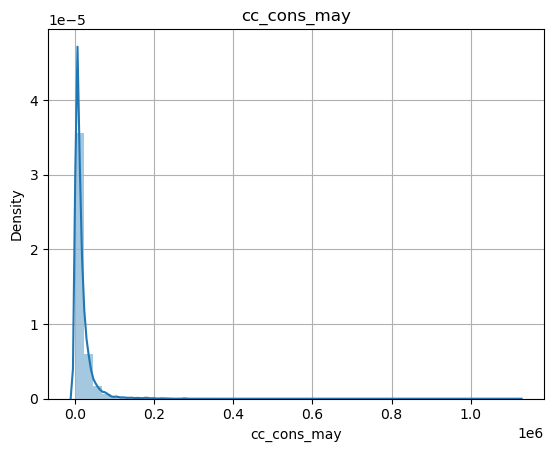

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


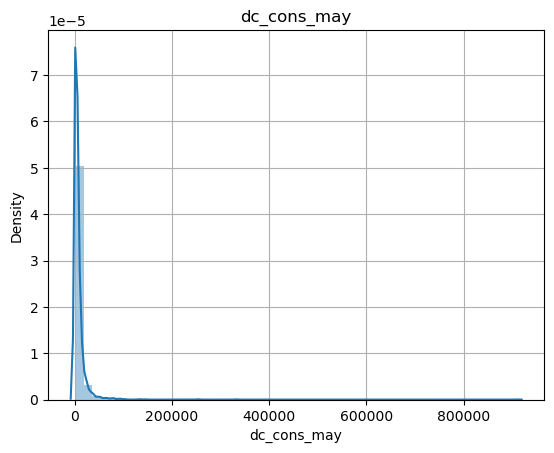

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


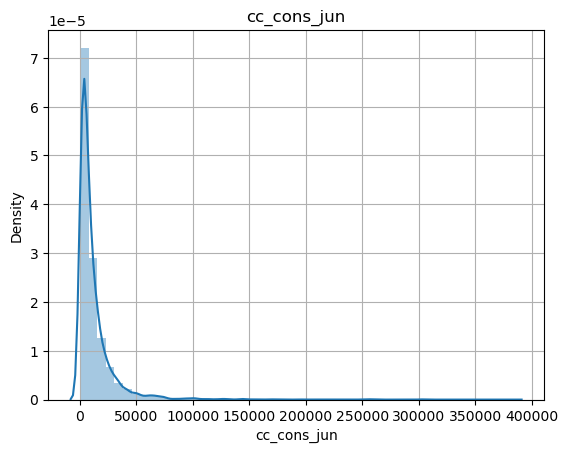

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


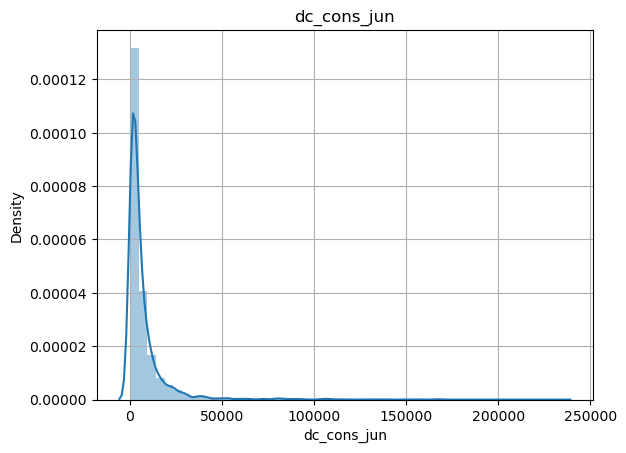

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


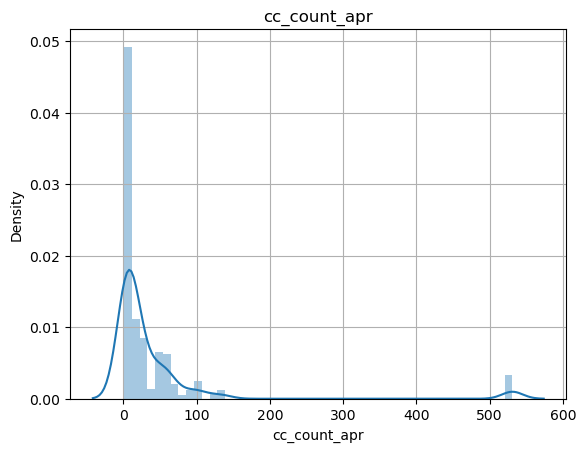

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


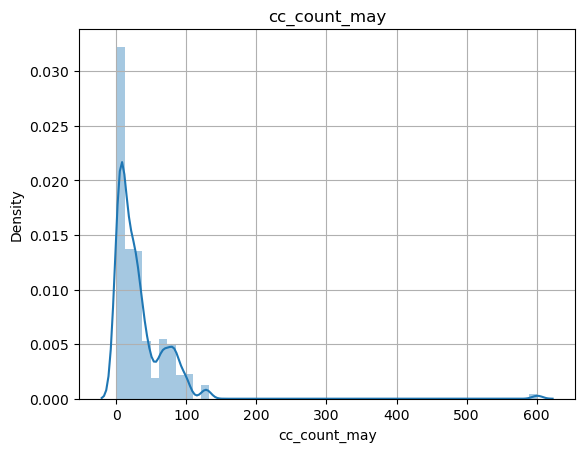

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


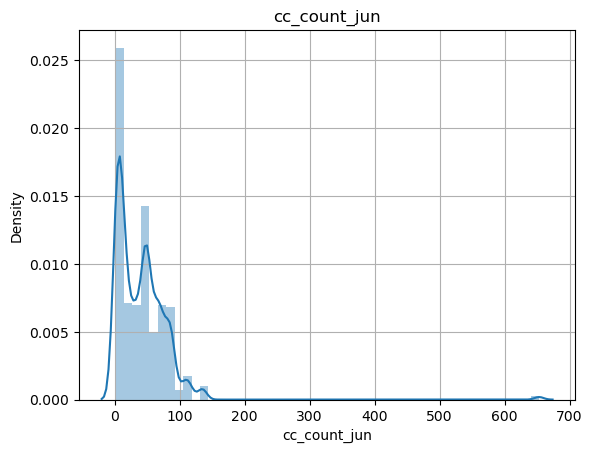

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


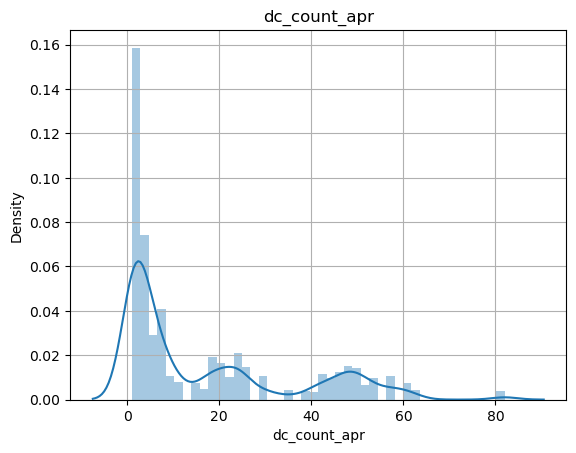

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


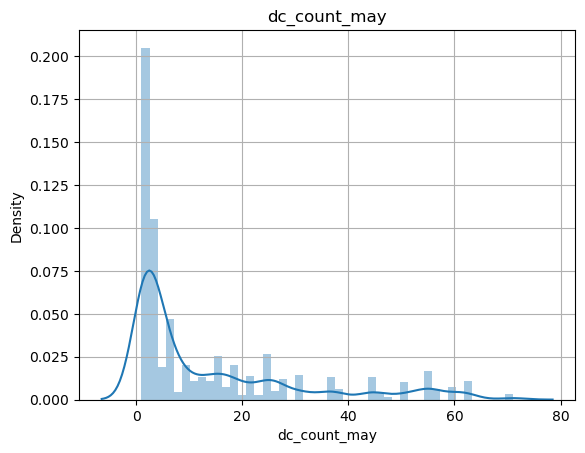

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


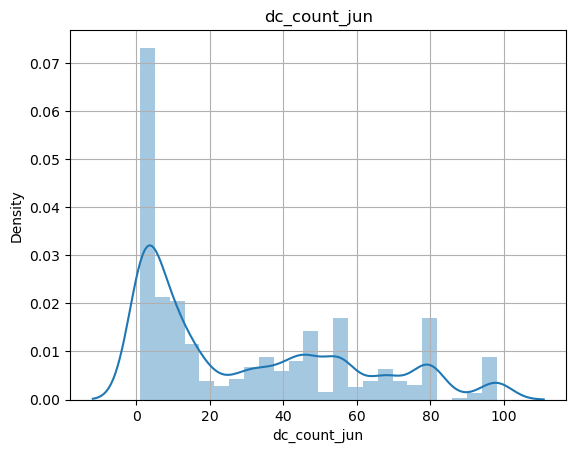

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


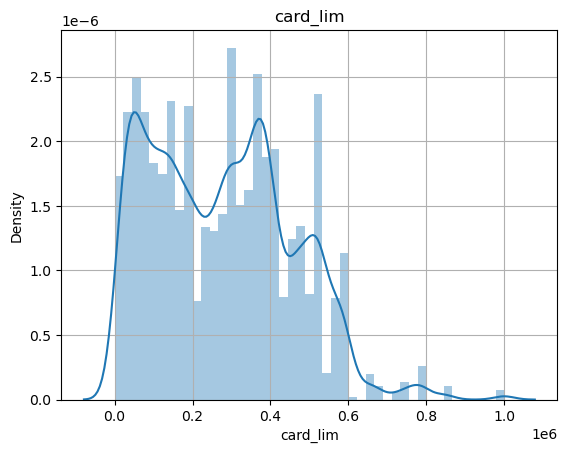

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])
C:\Users\pauld\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


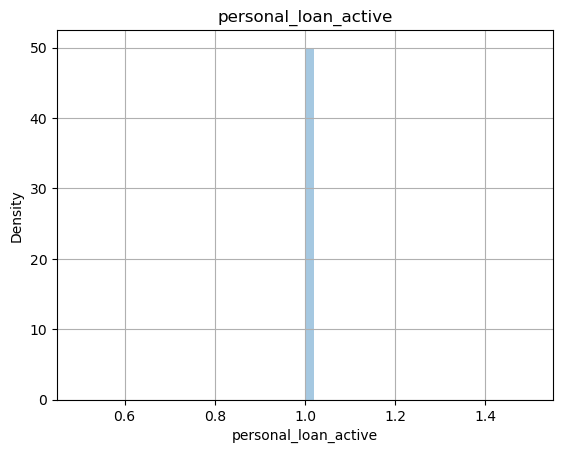

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])
C:\Users\pauld\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


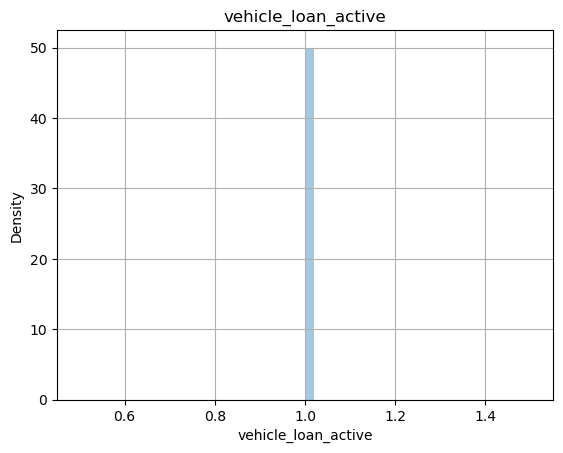

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])
C:\Users\pauld\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


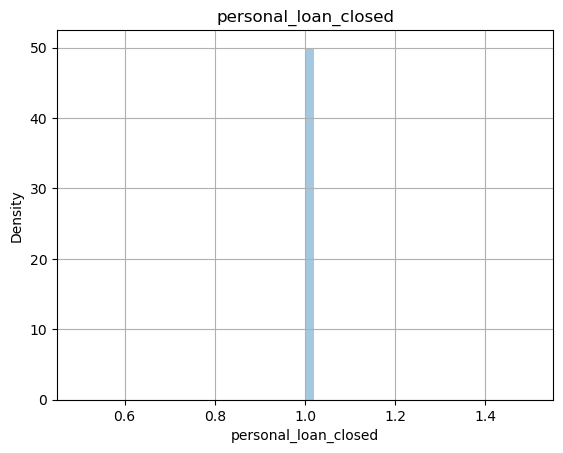

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])
C:\Users\pauld\anaconda3\Lib\site-packages\seaborn\distributions.py:2511: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


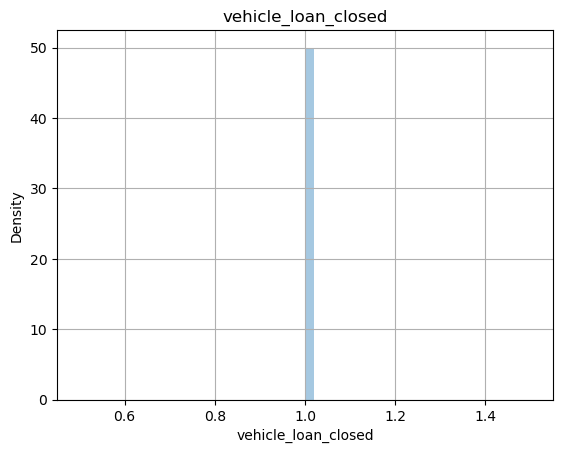

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


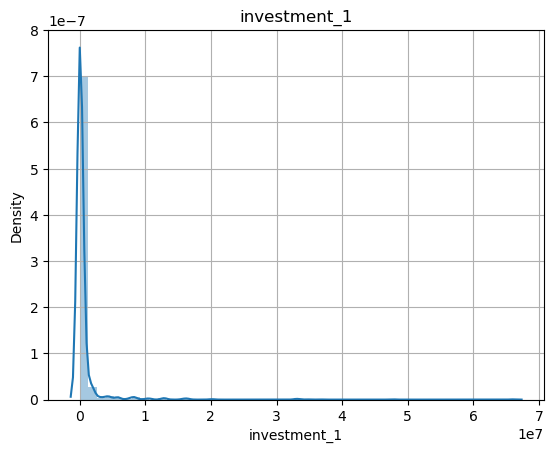

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


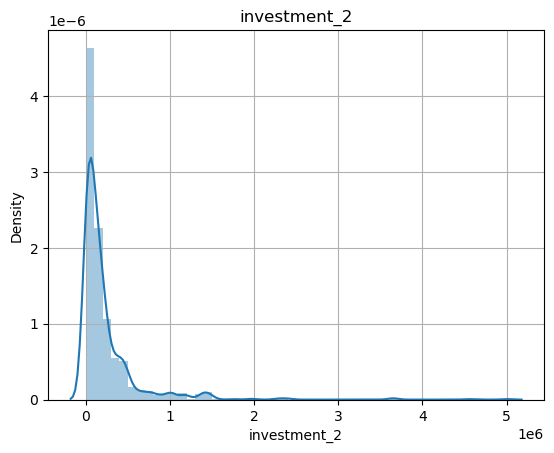

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


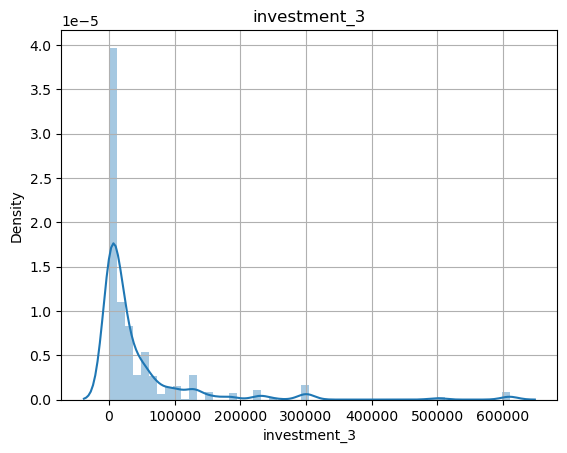

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


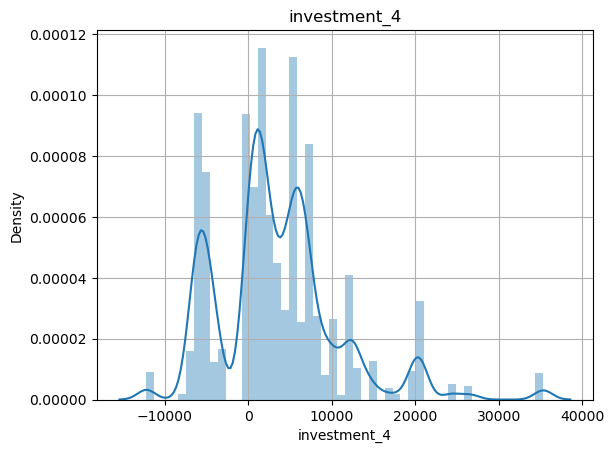

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


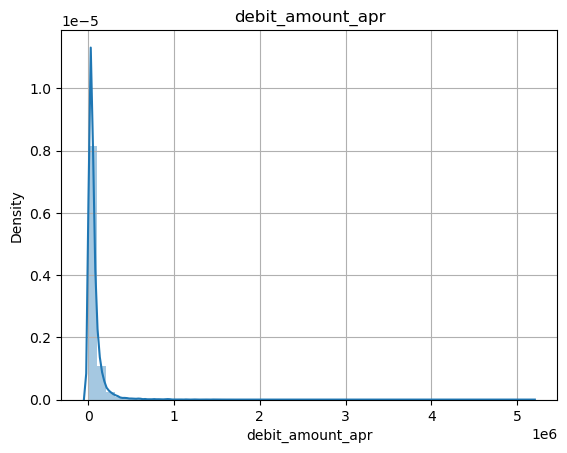

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


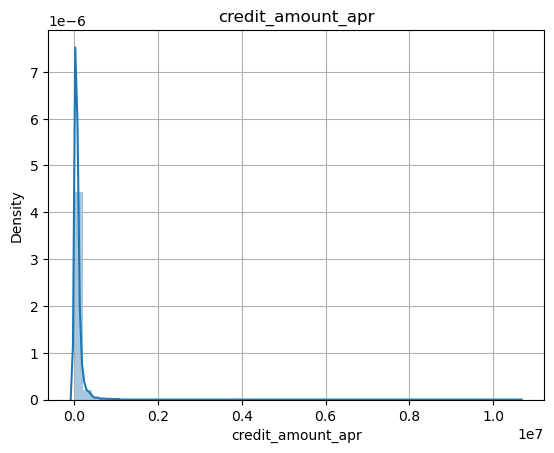

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


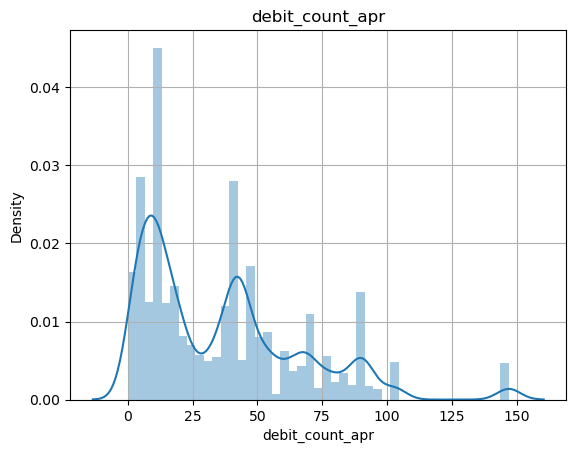

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


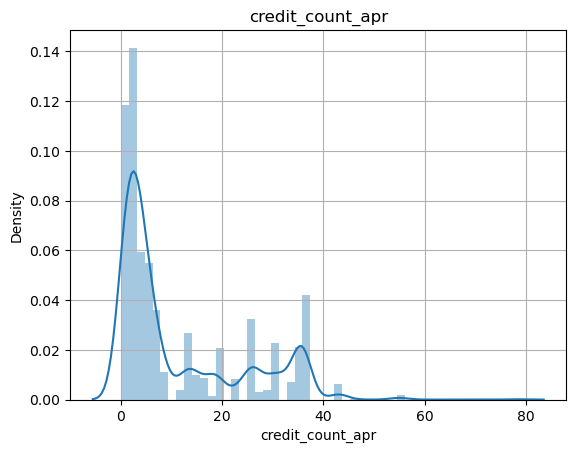

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


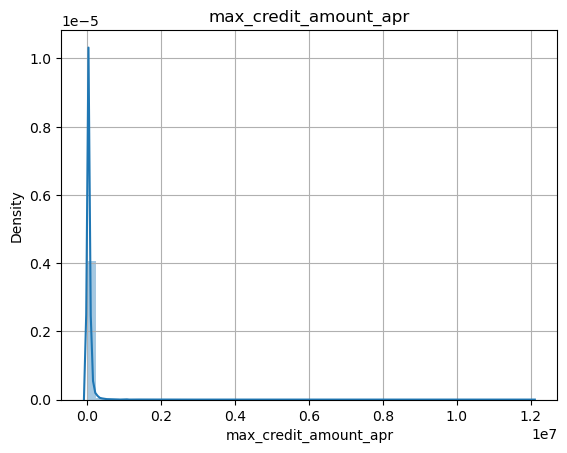

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


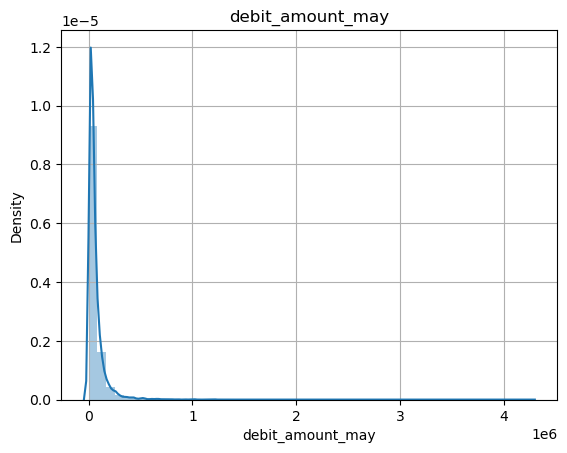

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


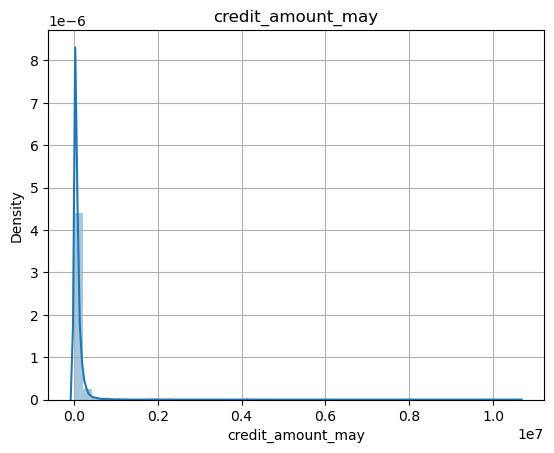

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


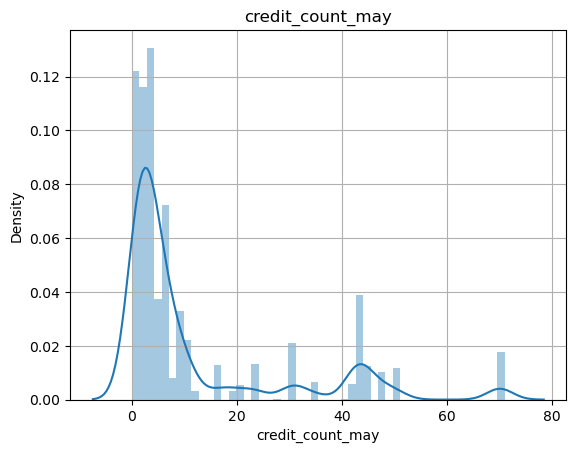

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


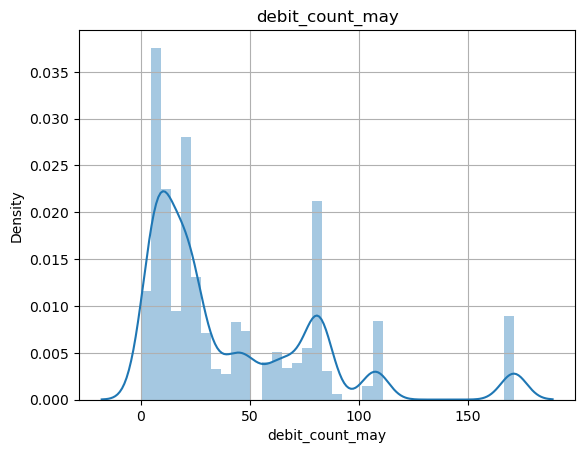

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


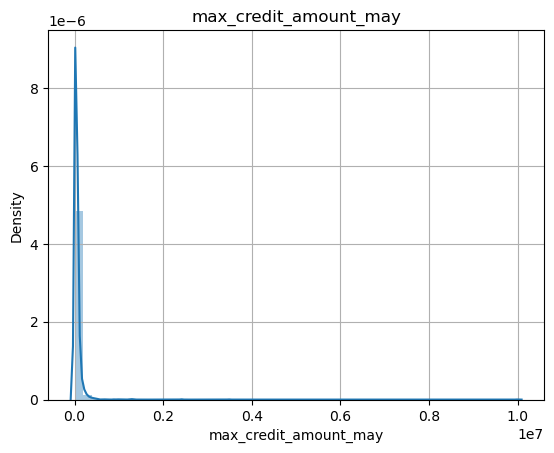

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


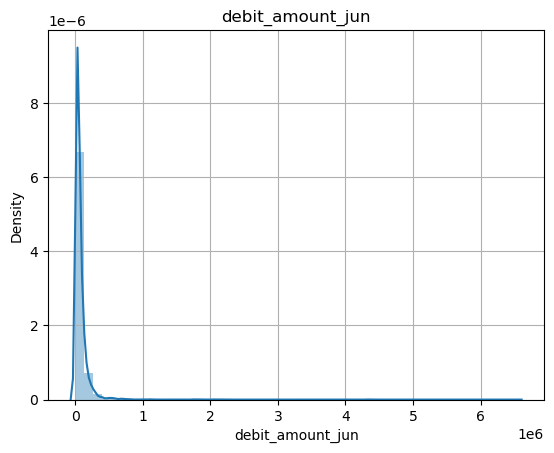

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


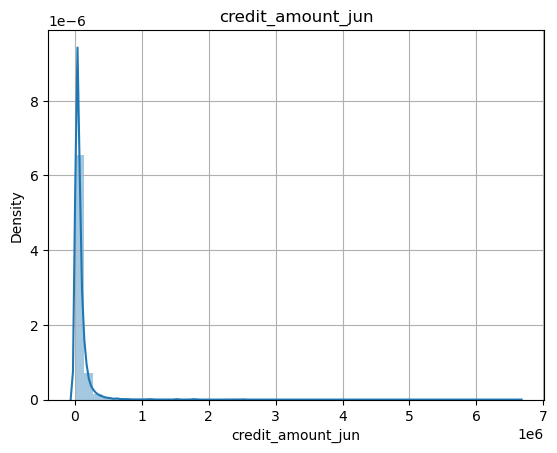

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


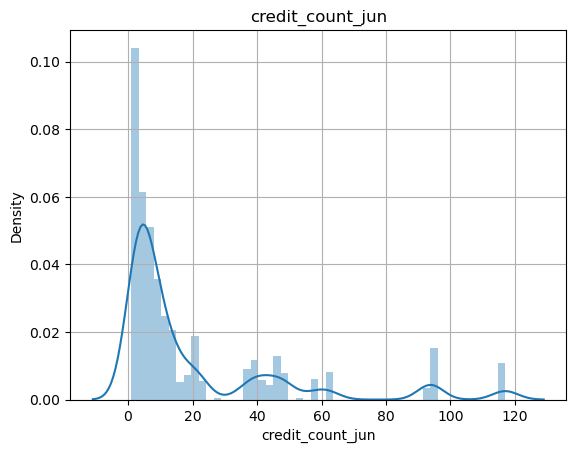

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


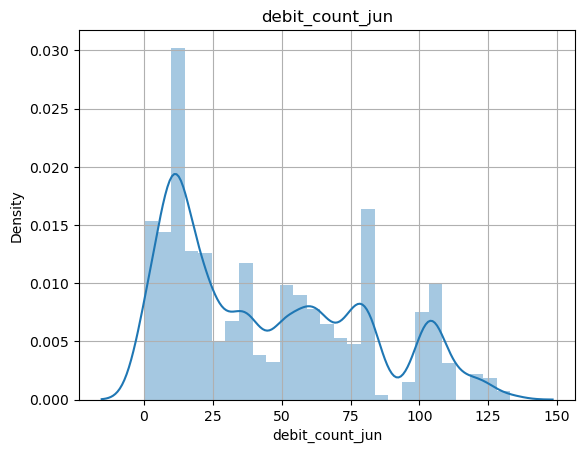

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


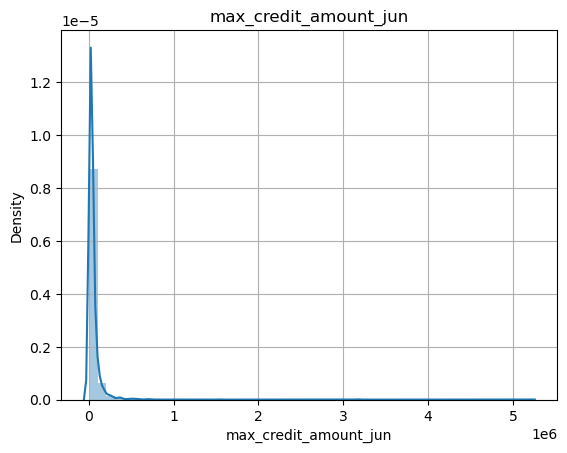

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


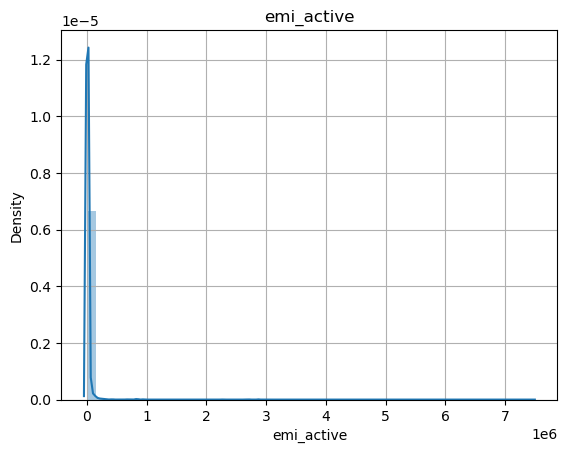

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


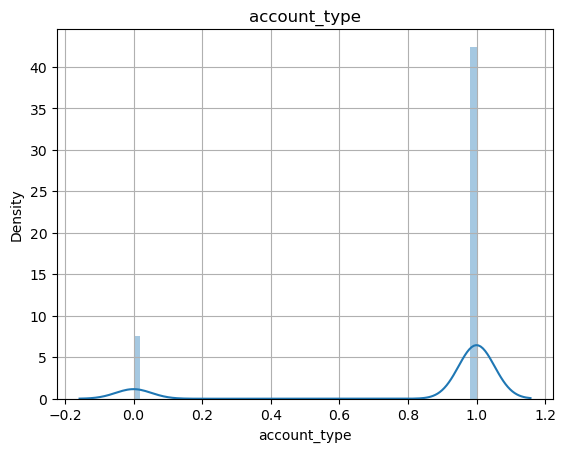

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


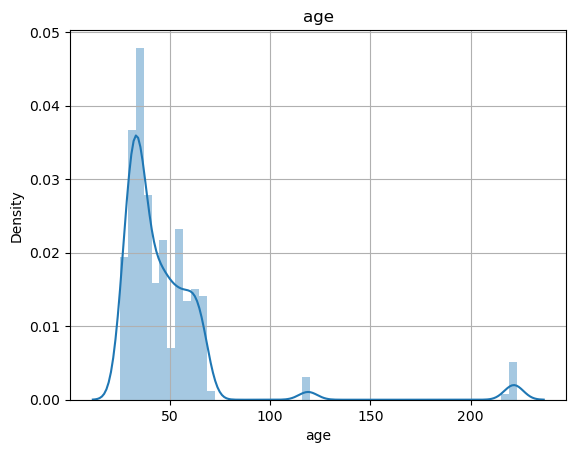

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


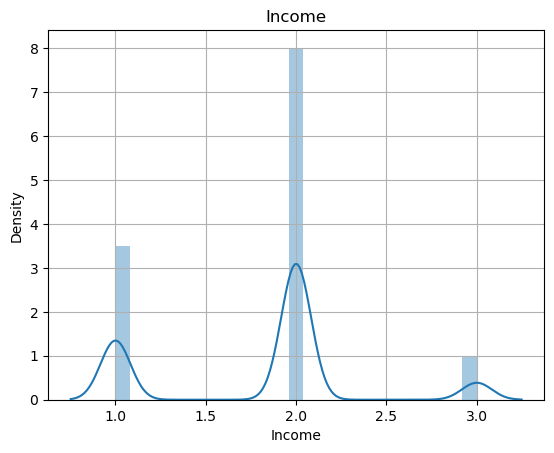

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


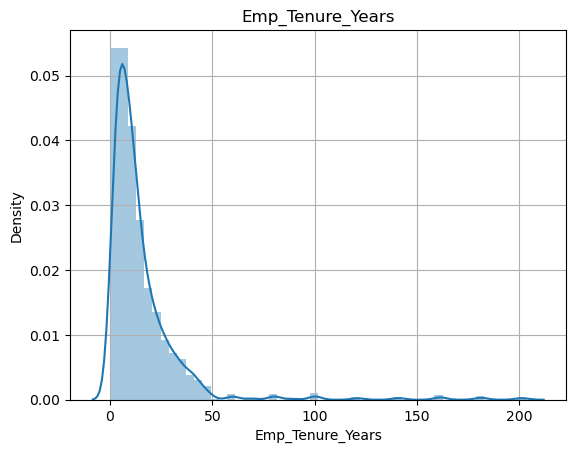

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


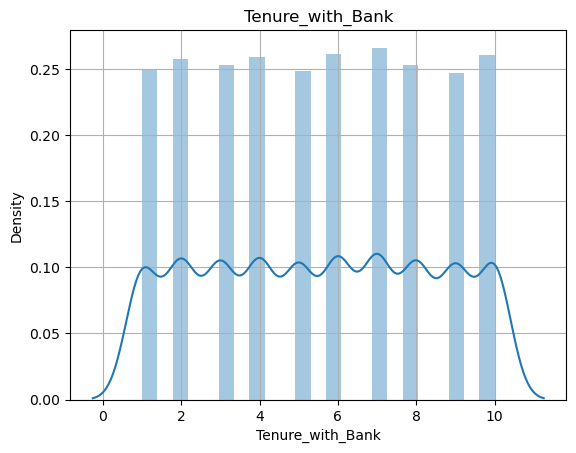

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


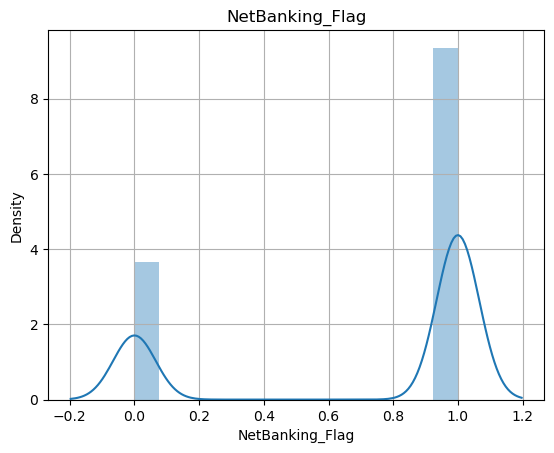

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4195182049.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[i])


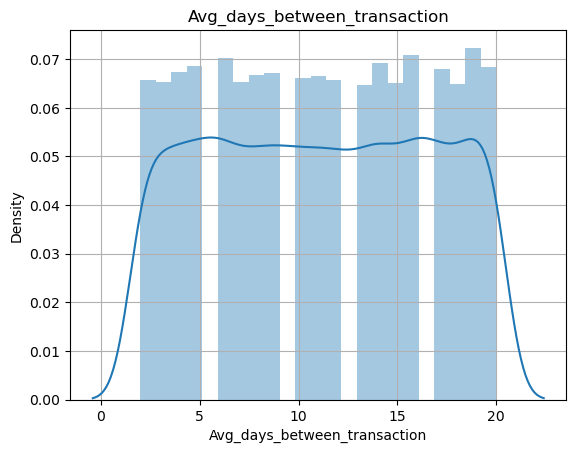

In [312]:
for i in column_names:
    plt.title(i)
    sns.distplot(df[i])
    plt.grid()
    plt.show()

Key takeaways::
1. cc_cons and dc_cons for the months are given. We should take their average and keep that as a independant feature.
2. There are outliers in the dataset. some of those solumns are age.
3. Some of the columns are redundant and should be dropped. eg. emi active column.
4. region code column is not required because there are too many regions and to avoid curse of dimentionality we will drop it.

In [313]:
df.head()

cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0      3412.60      2909.34      1077.36      3084.50      4615.97   
1     18133.76      3877.00      6123.78      5597.43     64620.00   
2      6363.65       735.49      8799.00     13768.00     38266.00   
3     12765.66      4429.16     16745.86      6360.00     29063.97   
4     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  dc_count_apr  ...  \
0       6693.0          19.0            10             2            53  ...   
1       6117.0           4.0            60             1             4  ...   
2       2638.0           2.0            83            47             4  ...   
3       3711.0          12.0             2            16            24  ...   
4       1065.0          15.0            13            61             7  ...   

   emi_active  account_type  gender  age  Income  Emp_Tenure_Years  \
0     3448.84             1       1   30       2               7.0   
1     3812.69             1       1   37       1              10.2   
2     9432.90             1       1   33       2               3.9   
3      144.61             1       1   63       1              25.8   
4     1887.89             0       1   33       2               6.5   

   Tenure_with_Bank  NetBanking_Flag  Avg_days_between_transaction  cc_cons  
0                 5                1                          20.0  13434.0  
1                 8                1                           5.0    449.0  
2                 3                1                          15.0  11968.0  
3                 6                0                          15.0  32029.0  
4                 7                0                           9.0  16394.0  

[5 rows x 46 columns]

## Bivariate Analysis

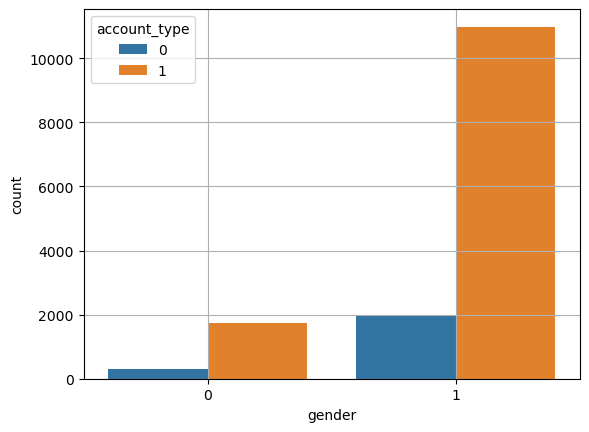

In [314]:
sns.countplot(x="gender", data=df,hue="account_type");
df.groupby(["gender" , "account_type"]).count()["age"]
plt.grid()

In [315]:
# the dataset contains majority of data for males. More customer have current account

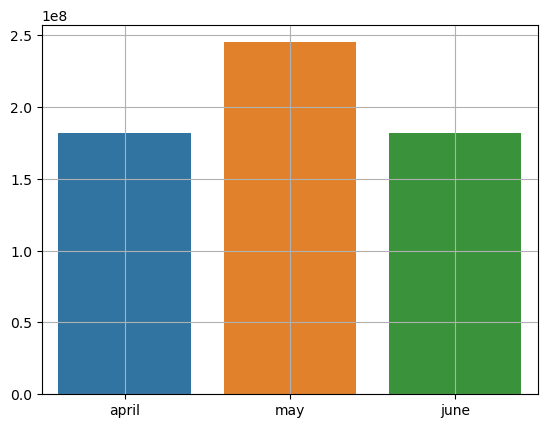

In [316]:
# credit card consumption over months
sns.barplot(x=["april", "may", "june"],y=[df["cc_cons_jun"].sum(),df['cc_cons_may'].sum(),df["cc_cons_jun"].sum()])
plt.grid()

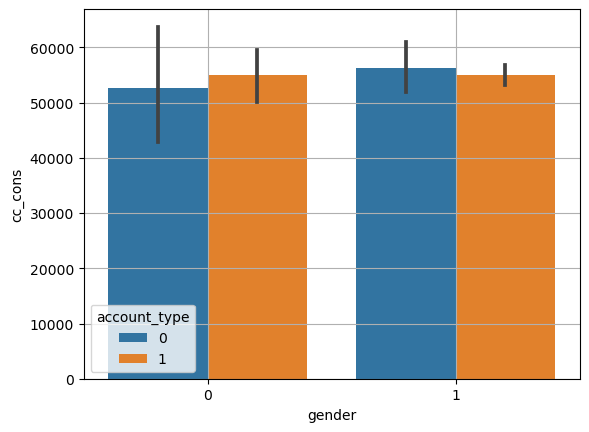

In [317]:
# gender vs cc_cons
sns.barplot(x="gender" , y="cc_cons",hue="account_type", data=df)
plt.grid()

In [318]:
# Consumption for males and females is almost same

In [319]:
df.groupby(by =  'age')['investment_1', 'investment_2', 'investment_3', 'investment_4'].sum()

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\222695865.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(by =  'age')['investment_1', 'investment_2', 'investment_3', 'investment_4'].sum()


investment_1  investment_2  investment_3  investment_4
age                                                        
25   3.559352e+07  2.359465e+07    4453680.00  3.855178e+05
27   2.730685e+08  1.224842e+08   27310264.86  1.549842e+06
28   3.228168e+08  1.136430e+08   24479470.00  1.677467e+06
29   2.596686e+08  1.010519e+08   20070473.00  1.523123e+06
30   5.466598e+08  1.871193e+08   31476394.58  2.680989e+06
31   1.583804e+08  4.625059e+07    7461340.86  6.800562e+05
32   5.332626e+08  1.964743e+08   31965011.00  2.774283e+06
33   7.248907e+08  2.887604e+08   54091165.00  4.237756e+06
34   2.847578e+08  1.266327e+08   26846039.00  2.091600e+06
35   4.600806e+08  1.758048e+08   33124400.86  3.216339e+06
36   1.304655e+08  4.427930e+07    9372828.86  8.446151e+05
37   5.111561e+08  1.821735e+08   29858789.00  2.245886e+06
38   1.694325e+08  7.944407e+07   12908413.00  1.130511e+06
39   4.742300e+07  2.727390e+07    6163305.00  4.875845e+05
40   2.542278e+08  9.819416e+07   20352009.00  1.517056e+06
42   3.955338e+08  1.300230e+08   25220299.00  2.142918e+06
44   2.246110e+08  7.075275e+07   14640023.86  1.282799e+06
46   1.995698e+08  9.656294e+07   16377885.72  1.317188e+06
47   5.853849e+08  2.158413e+08   41248994.86  3.597515e+06
49   1.025573e+08  4.133123e+07    9130823.00  5.310157e+05
50   8.743701e+07  3.218333e+07    6784280.00  5.190501e+05
51   3.604531e+07  3.165322e+07    4592974.00  4.282166e+05
53   5.372302e+08  2.002693e+08   35682470.86  2.826133e+06
54   1.173686e+07  4.103449e+06     880179.00  7.674338e+04
55   3.851999e+08  8.916627e+07   17430915.86  1.683892e+06
56   1.598140e+08  3.746504e+07    7674201.00  5.394243e+05
58   1.332631e+08  7.334924e+07   12858449.86  1.262667e+06
60   3.798239e+08  1.221916e+08   20509574.00  1.506799e+06
61   6.019481e+07  9.461519e+06    3369885.00  2.086512e+05
62   2.686956e+08  1.110949e+08   21213862.00  1.553465e+06
63   5.021692e+07  3.359604e+07    9179213.00  6.525522e+05
64   6.719529e+07  4.760835e+07    8619578.00  5.913253e+05
65   2.502092e+06  2.467728e+06     160976.00  7.383051e+04
66   4.676172e+08  1.624069e+08   31617254.00  2.489547e+06
67   2.326845e+07  1.926361e+07    6757186.00  2.242884e+05
69   7.605526e+07  1.534016e+07    2742479.00  3.501487e+05
118  4.446816e+07  2.654906e+07    6078737.86  3.960909e+05
120  4.865551e+07  2.112396e+07    3740234.00  2.123278e+05
219  6.671557e+06  1.543108e+07    1112990.00  1.963906e+05
220  4.561197e+07  1.132343e+07    3482620.00  2.110419e+05
221  1.149171e+07  9.367657e+06    3159775.00  2.323708e+05
222  4.520033e+07  2.490096e+07    5309378.00  2.647882e+05
223  1.230655e+08  3.168627e+07    6170947.00  4.152883e+05

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\4179093644.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.scatterplot(df.groupby(by =  'age')['investment_1', 'investment_2', 'investment_3', 'investment_4'].sum())


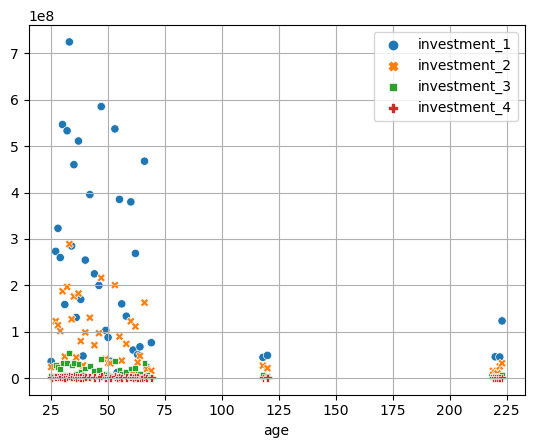

In [320]:
sns.scatterplot(df.groupby(by =  'age')['investment_1', 'investment_2', 'investment_3', 'investment_4'].sum())
plt.grid()

In [321]:
# we need to treat these age>100.
# investment 1 is highest among all peer groups followed by investment 2 , 3 and 4 respectively.
# We will sum the investments

In [322]:
# checking each column for outliers

In [323]:
df.Emp_Tenure_Years.value_counts()

6.0      293
12.0     286
7.2      252
10.8     246
9.0      239
        ... 
179.1      2
120.6      1
34.0       1
23.8       1
22.5       1
Name: Emp_Tenure_Years, Length: 270, dtype: int64

In [324]:
# there is a problem in this column. Practically no one can use bank account for 120, 179 etc years. 
# we need to treat this column for outliers.

In [325]:
# age column 
df.age.value_counts()

33     1290
47      921
32      808
53      764
35      758
66      731
37      719
30      709
42      602
34      581
28      533
27      517
60      476
62      474
40      463
29      453
55      393
46      367
38      340
44      340
58      323
36      215
31      213
56      195
64      186
63      165
49      159
50      141
39      136
51      116
223     111
25      106
222     101
118      99
67       93
120      83
69       72
61       67
220      52
219      47
221      41
54       25
65       10
Name: age, dtype: int64

In [326]:
# this column also has some issues as age of > 200 is not possible so we will treat this column for outliers

CC_cons cannot be changed since it is a dependant variable.

In [327]:
# credit_lim also needs to be taken care of 

cc_cons for different months should be kept as it is since this would determine cc_cons. We will use some aggregation function to combine the similar column and then delete the remaining.

In [328]:
df.columns

Index(['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'vehicle_loan_active',
       'personal_loan_closed', 'vehicle_loan_closed', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'emi_active',
       'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years',
       'Tenure_with_Bank', 'NetBanking_Flag', 'Avg_days_between_transaction',
       'cc_cons'],
      dtype='object')

In [329]:
df.vehicle_loan_active.value_counts()

1    14995
Name: vehicle_loan_active, dtype: int64

In [330]:
# checking the rows where vehicle loan was given 
df.vehicle_loan_active.value_counts(), df.vehicle_loan_closed.value_counts()

(1    14995
 Name: vehicle_loan_active, dtype: int64,
 1    14995
 Name: vehicle_loan_closed, dtype: int64)

In [331]:
# Checking total rows of data
df.count()

cc_cons_apr                     14995
dc_cons_apr                     14995
cc_cons_may                     14995
dc_cons_may                     14995
cc_cons_jun                     14995
dc_cons_jun                     14995
cc_count_apr                    14995
cc_count_may                    14995
cc_count_jun                    14995
dc_count_apr                    14995
dc_count_may                    14995
dc_count_jun                    14995
card_lim                        14995
personal_loan_active            14995
vehicle_loan_active             14995
personal_loan_closed            14995
vehicle_loan_closed             14995
investment_1                    14995
investment_2                    14995
investment_3                    14995
investment_4                    14995
debit_amount_apr                14995
credit_amount_apr               14995
debit_count_apr                 14995
credit_count_apr                14995
max_credit_amount_apr           14995
debit_amount

It means every customer has taken the vehicle loan in the past and the active loan is from another bank. We will remove the columns for vehicle loan.

In [332]:
df.drop(columns= ['vehicle_loan_active', 'vehicle_loan_closed'], inplace= True)

In [333]:
# doing the same for the unseen dataset
df1.drop(columns= ['vehicle_loan_active', 'vehicle_loan_closed'], inplace= True)

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\1325604236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns= ['vehicle_loan_active', 'vehicle_loan_closed'], inplace= True)


In [334]:
df.head()

cc_cons_apr  dc_cons_apr  cc_cons_may  dc_cons_may  cc_cons_jun  \
0      3412.60      2909.34      1077.36      3084.50      4615.97   
1     18133.76      3877.00      6123.78      5597.43     64620.00   
2      6363.65       735.49      8799.00     13768.00     38266.00   
3     12765.66      4429.16     16745.86      6360.00     29063.97   
4     27819.70      1944.00      7006.50      2228.50      1096.25   

   dc_cons_jun  cc_count_apr  cc_count_may  cc_count_jun  dc_count_apr  ...  \
0       6693.0          19.0            10             2            53  ...   
1       6117.0           4.0            60             1             4  ...   
2       2638.0           2.0            83            47             4  ...   
3       3711.0          12.0             2            16            24  ...   
4       1065.0          15.0            13            61             7  ...   

   emi_active  account_type  gender  age  Income  Emp_Tenure_Years  \
0     3448.84             1       1   30       2               7.0   
1     3812.69             1       1   37       1              10.2   
2     9432.90             1       1   33       2               3.9   
3      144.61             1       1   63       1              25.8   
4     1887.89             0       1   33       2               6.5   

   Tenure_with_Bank  NetBanking_Flag  Avg_days_between_transaction  cc_cons  
0                 5                1                          20.0  13434.0  
1                 8                1                           5.0    449.0  
2                 3                1                          15.0  11968.0  
3                 6                0                          15.0  32029.0  
4                 7                0                           9.0  16394.0  

[5 rows x 44 columns]

all other columns we will treat them

In [335]:
df.columns

Index(['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'personal_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'account_type', 'gender', 'age', 'Income',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'NetBanking_Flag',
       'Avg_days_between_transaction', 'cc_cons'],
      dtype='object')

In [336]:
column_names = ['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'personal_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'account_type', 'gender', 'age', 'Income',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'NetBanking_Flag',
       'Avg_days_between_transaction']

In [337]:
def outlier_treatment(var):
    uc = var.quantile(0.75)
    lc = var.quantile(0.25)
    iqr = (uc - lc)
    lower_bound = lc - iqr/2
    upper_bound = uc + iqr/2
    return var.clip(lower=lower_bound, upper=upper_bound)


In [338]:
# checking for emi active column
df.emi_active.value_counts()

0.00        35
34723.41    17
1584.63     15
40438.02    15
22219.32    14
            ..
2161.01      1
558.51       1
40311.45     1
7812.52      1
13006.84     1
Name: emi_active, Length: 5393, dtype: int64

In [339]:
df.columns

Index(['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'personal_loan_closed',
       'investment_1', 'investment_2', 'investment_3', 'investment_4',
       'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr',
       'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may',
       'credit_amount_may', 'credit_count_may', 'debit_count_may',
       'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun',
       'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun',
       'emi_active', 'account_type', 'gender', 'age', 'Income',
       'Emp_Tenure_Years', 'Tenure_with_Bank', 'NetBanking_Flag',
       'Avg_days_between_transaction', 'cc_cons'],
      dtype='object')

In [340]:
column_names = ['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income',
       'NetBanking_Flag', 'Tenure_with_Bank', 'age',
       'card_lim', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may',
       'cc_count_apr', 'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'credit_count_apr',
       'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_apr', 'dc_count_jun', 'dc_count_may',
       'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may',
       'debit_count_apr', 'debit_count_jun', 'debit_count_may', 'emi_active', 'investment_1', 
        'investment_2', 'investment_3',
       'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun',
       'max_credit_amount_may', 'personal_loan_active', 'personal_loan_closed']

In [341]:
for i in column_names:
    df[i] = outlier_treatment(df[i])

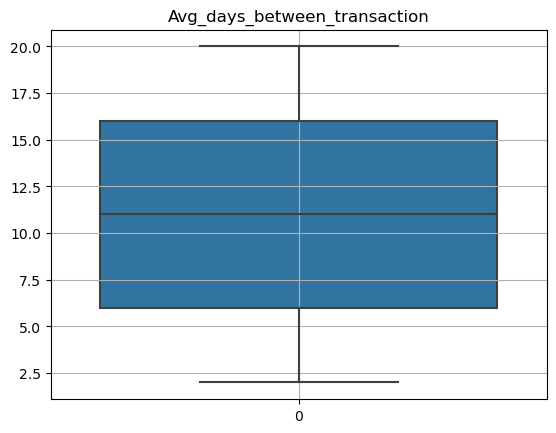

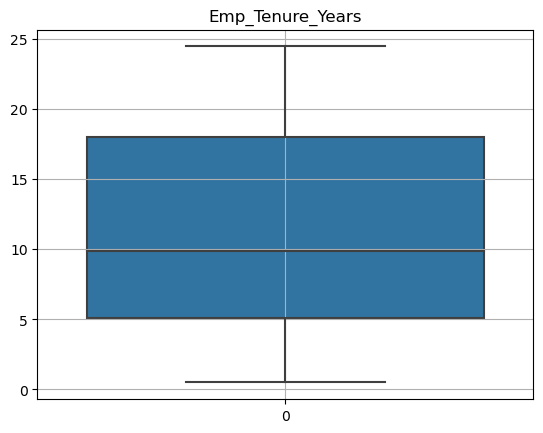

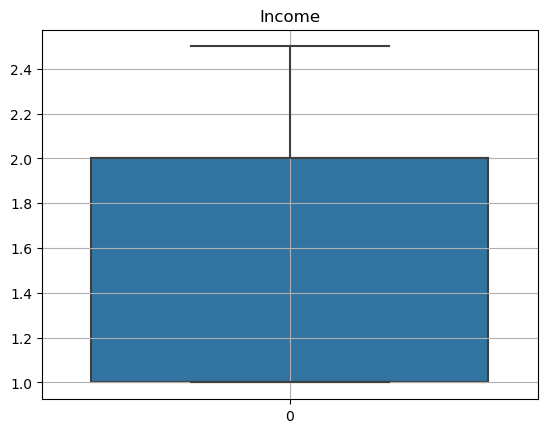

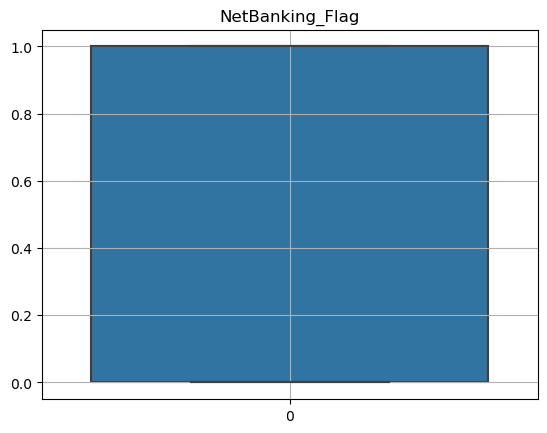

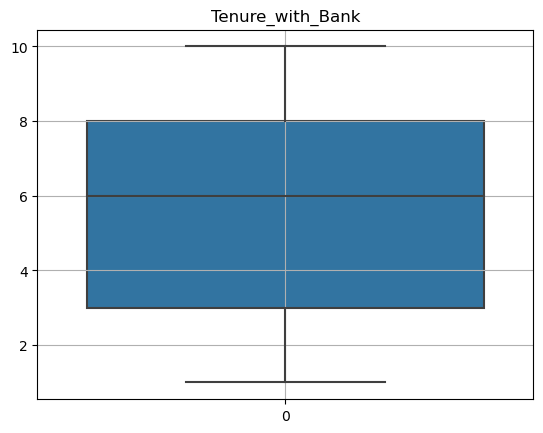

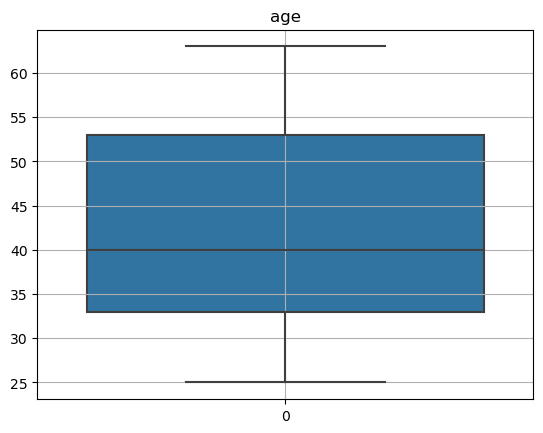

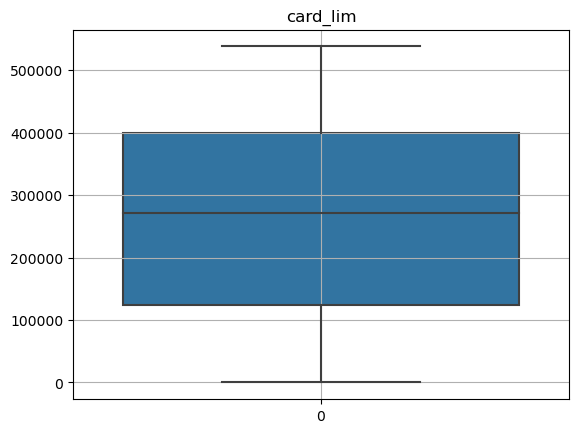

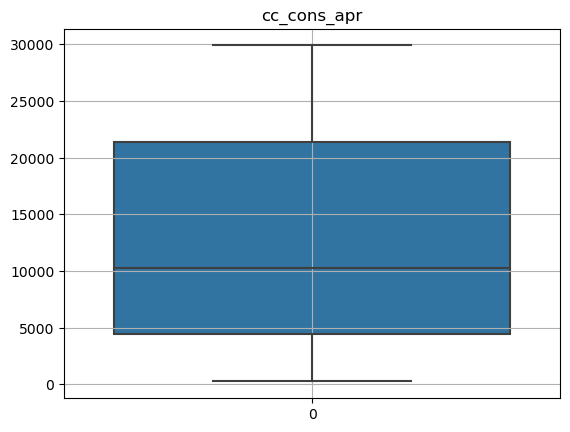

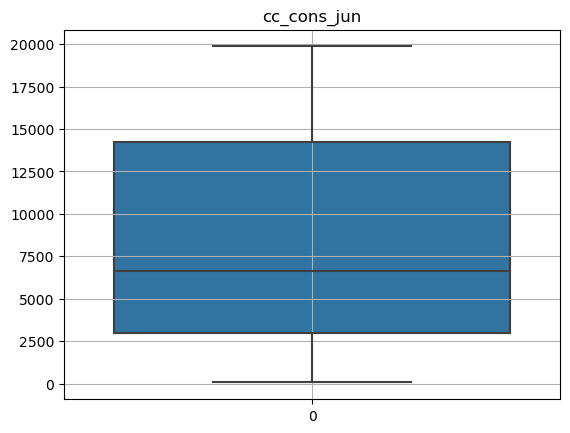

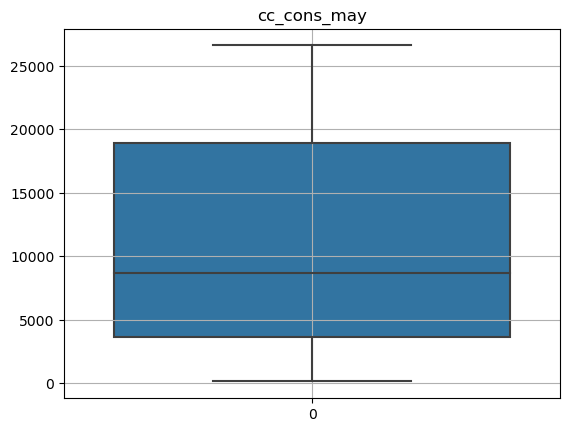

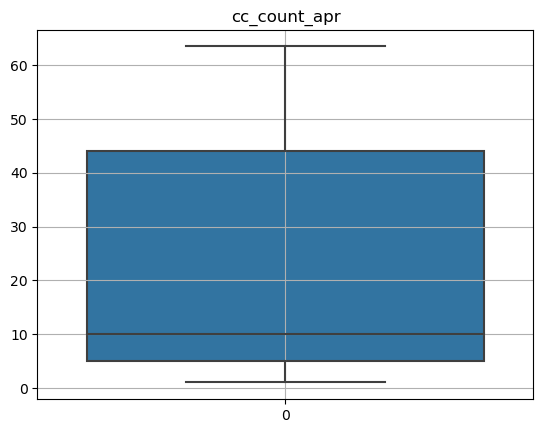

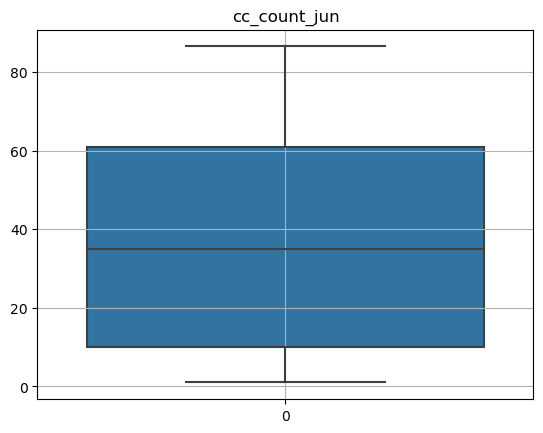

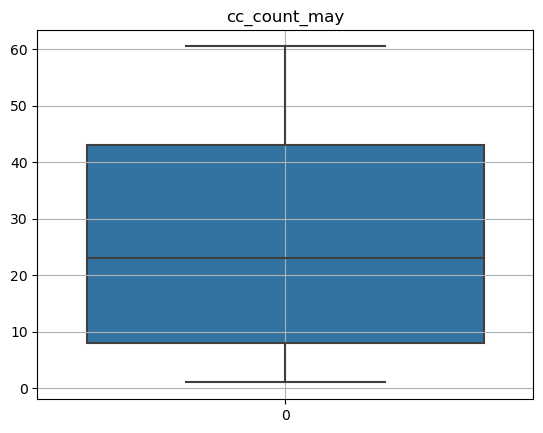

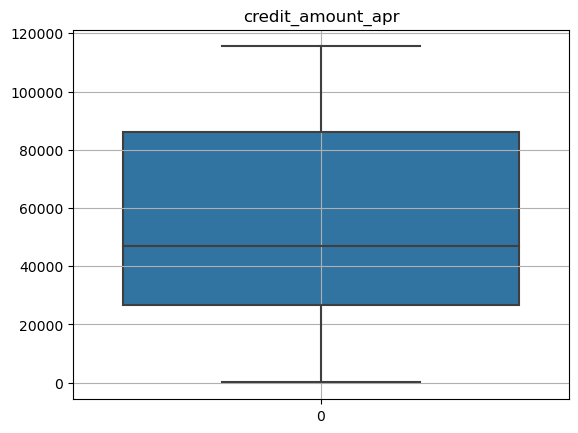

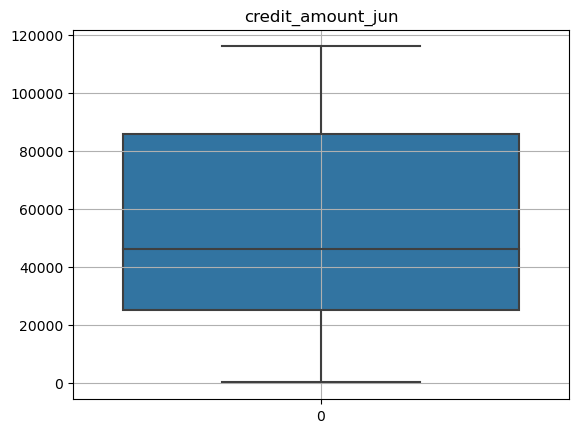

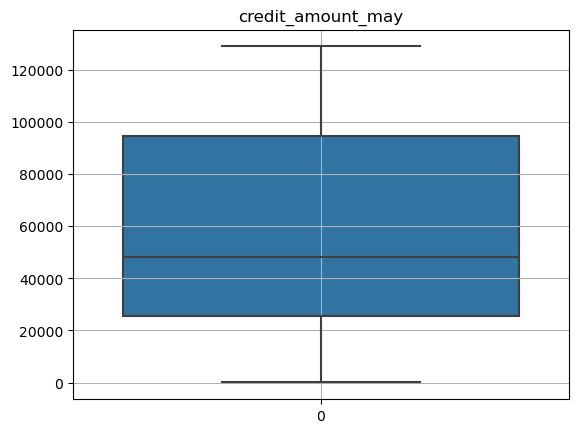

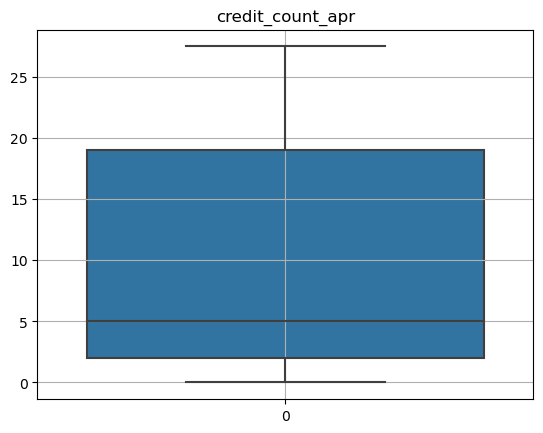

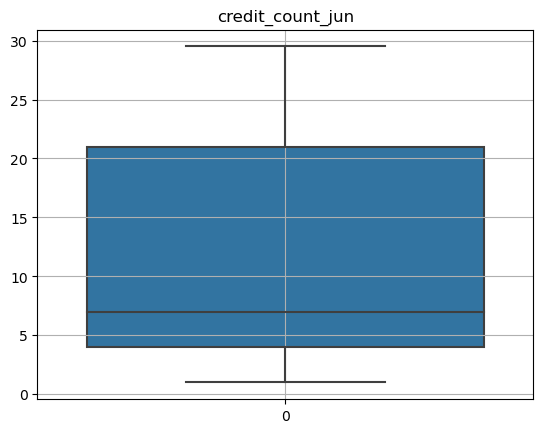

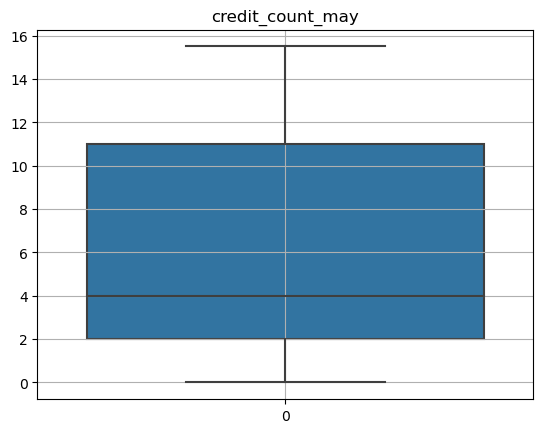

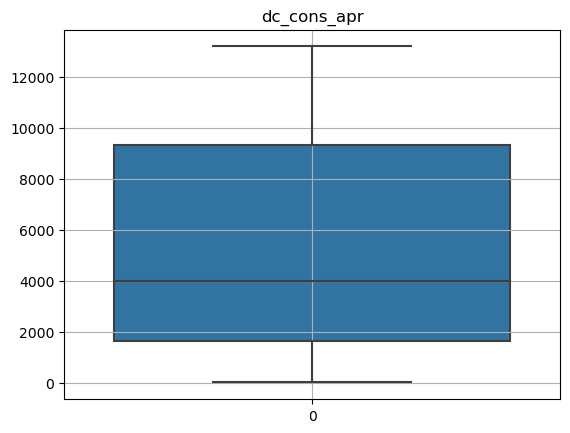

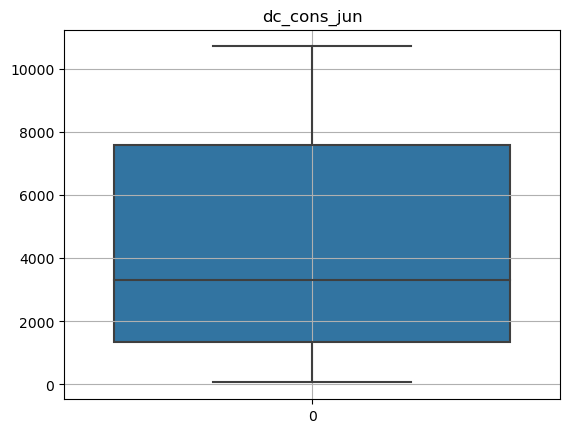

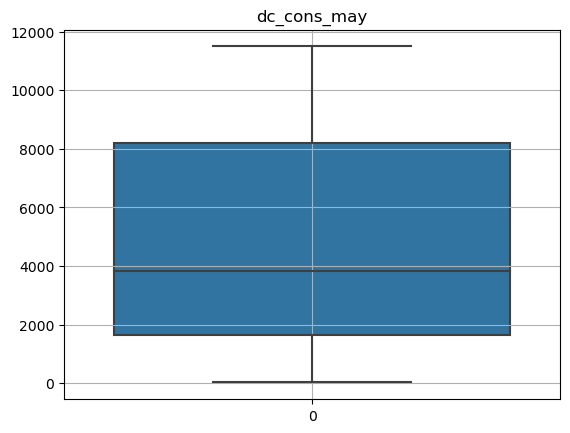

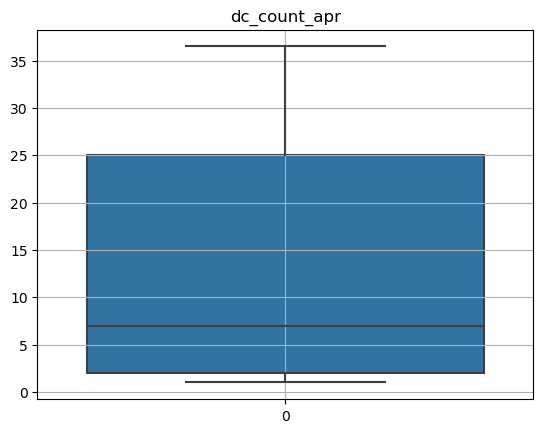

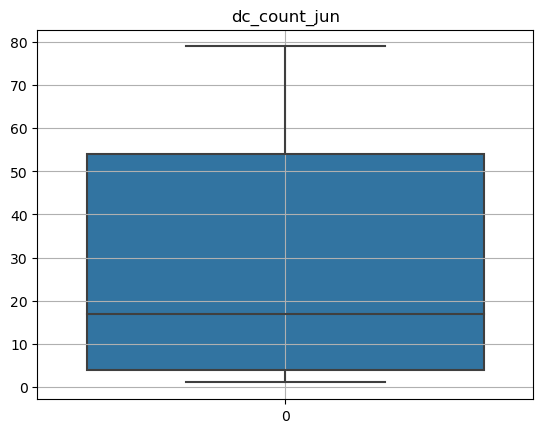

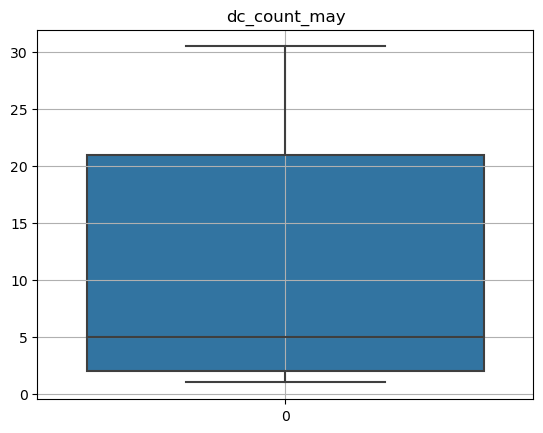

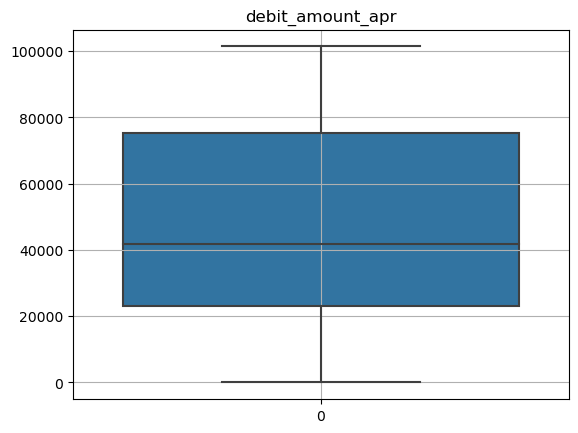

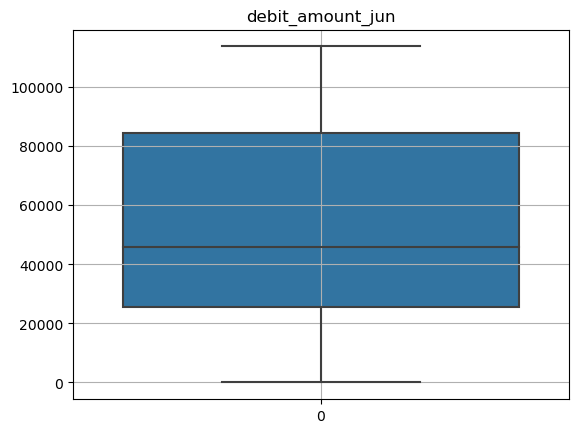

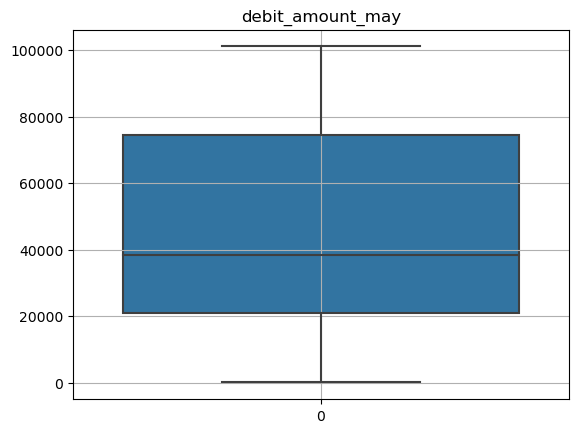

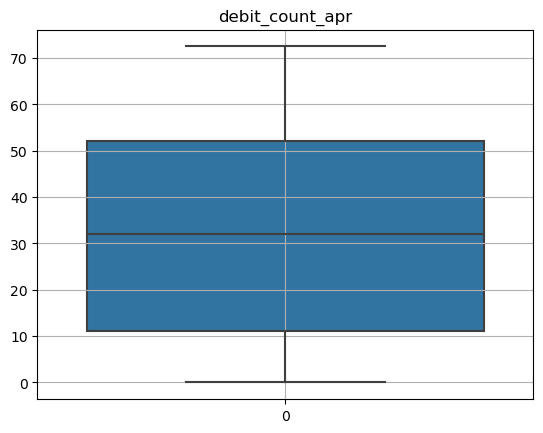

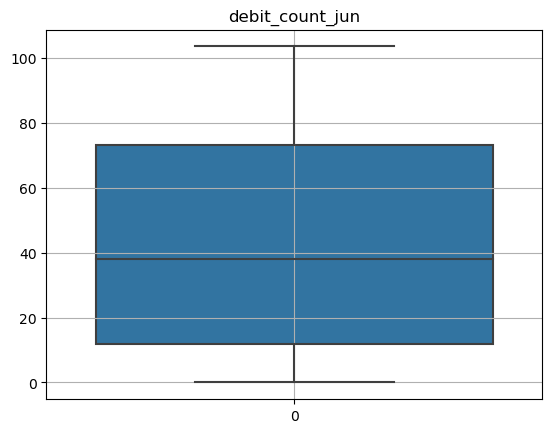

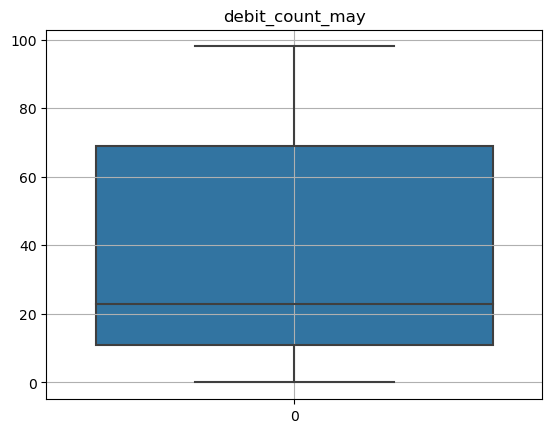

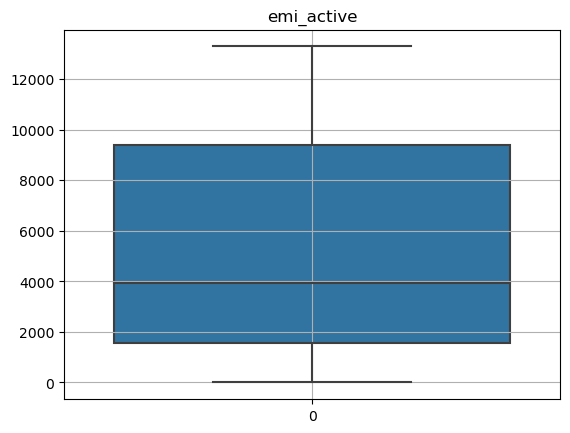

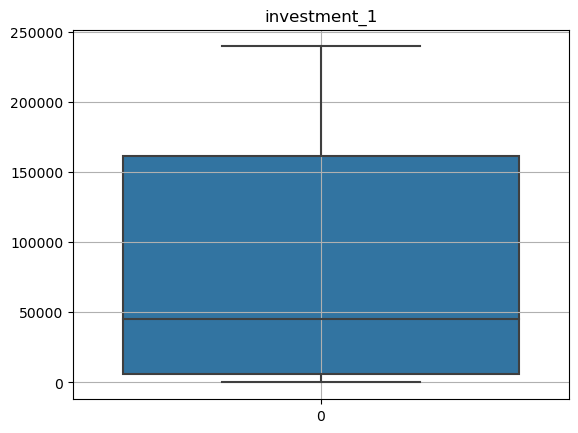

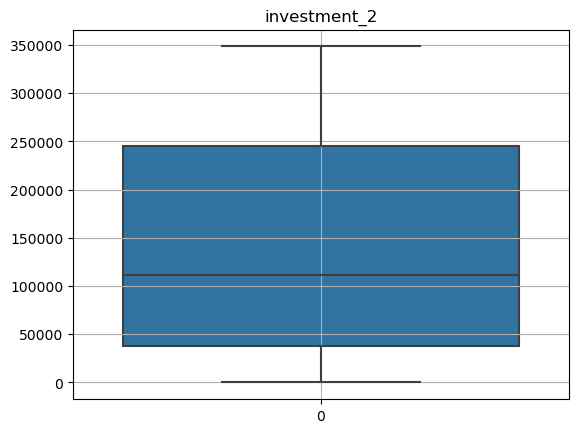

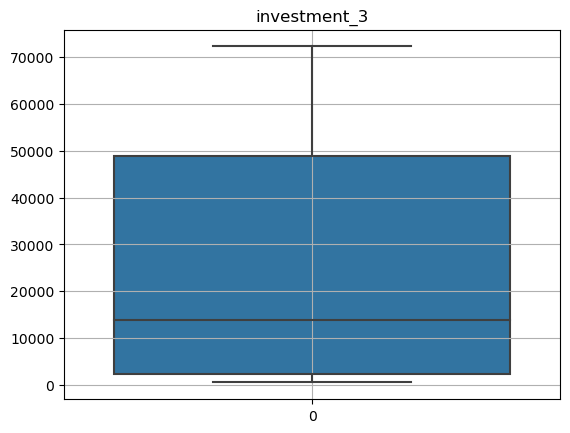

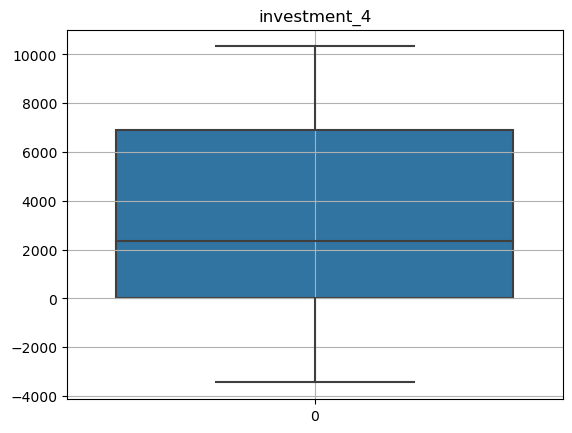

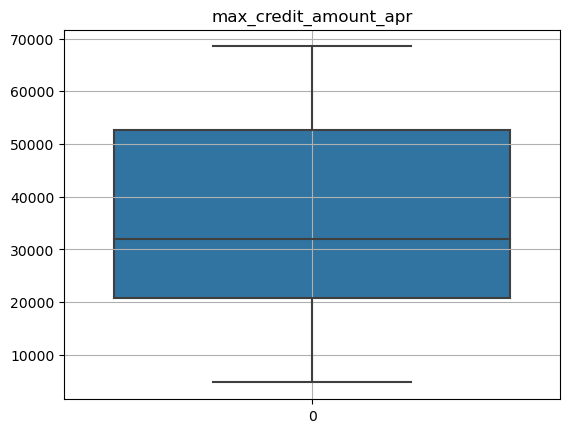

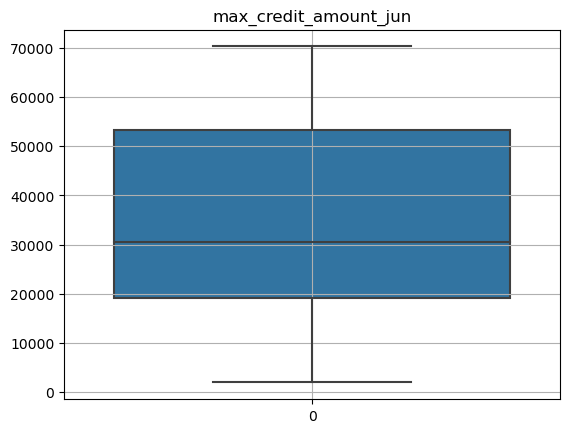

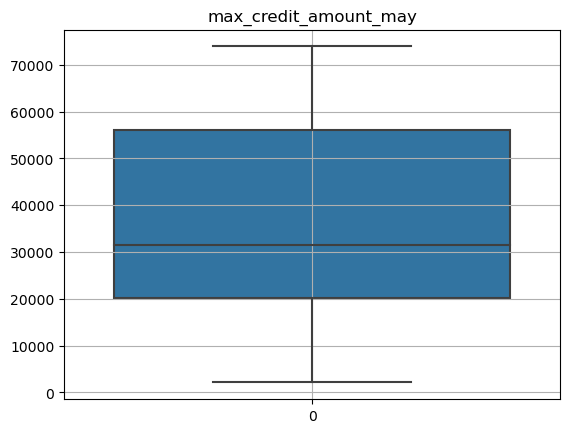

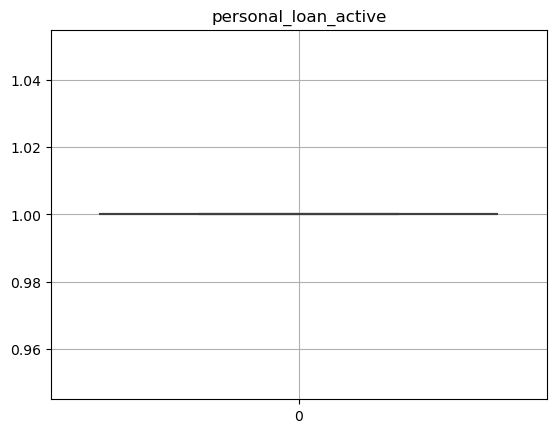

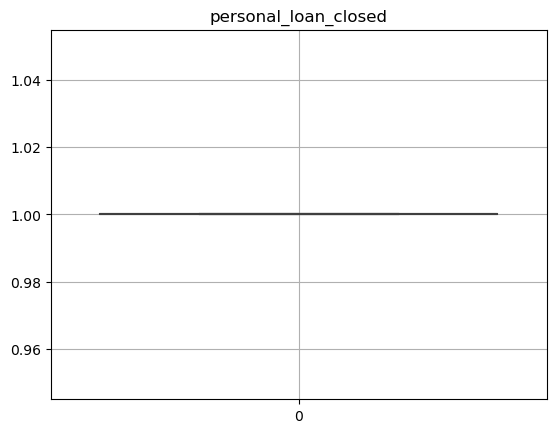

In [342]:
# checking for outliers again
for i in column_names:
    plt.title(i)
    sns.boxplot(df[i])
    plt.grid()
    plt.show()

Outliers have been corrected for each feature. Every feature is free of outliers. we will delete ID column once we train the model.

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\3183579355.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.cc_cons)


<Axes: xlabel='cc_cons', ylabel='Density'>

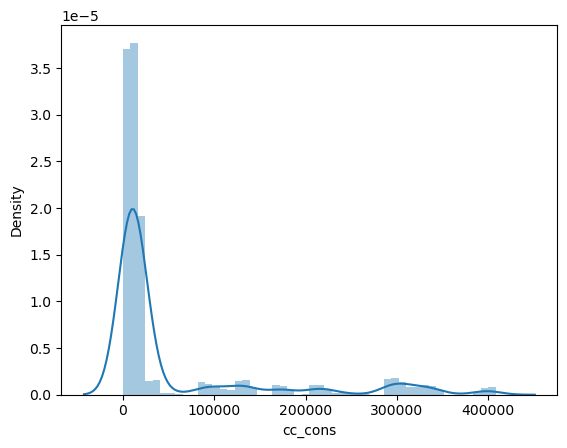

In [82]:
# Plotting the dependant variable
sns.distplot(df.cc_cons)

In [83]:
df.cc_cons.kurtosis()

3.2625631382721947

In [84]:
# data is highly skewed 

In [85]:
df.corr()

cc_cons_apr  dc_cons_apr  cc_cons_may  \
cc_cons_apr                      1.000000    -0.006889     0.017380   
dc_cons_apr                     -0.006889     1.000000    -0.017009   
cc_cons_may                      0.017380    -0.017009     1.000000   
dc_cons_may                      0.001126     0.001394    -0.002466   
cc_cons_jun                     -0.020557    -0.007938    -0.007995   
dc_cons_jun                      0.000506    -0.008676     0.001746   
cc_count_apr                    -0.004059     0.002231    -0.017433   
cc_count_may                    -0.000948     0.011108     0.010444   
cc_count_jun                     0.011335     0.001413    -0.003110   
dc_count_apr                    -0.001264     0.006641    -0.003461   
dc_count_may                    -0.018363     0.022768    -0.004109   
dc_count_jun                     0.011324     0.013267     0.004306   
card_lim                        -0.006173    -0.003305     0.019775   
personal_loan_active                  NaN          NaN          NaN   
personal_loan_closed                  NaN          NaN          NaN   
investment_1                    -0.008956    -0.006280    -0.011272   
investment_2                     0.003523    -0.002376    -0.003813   
investment_3                    -0.006429     0.002134    -0.005914   
investment_4                     0.001057    -0.002832     0.000958   
debit_amount_apr                 0.004244     0.000410    -0.003712   
credit_amount_apr                0.004861     0.001044    -0.005795   
debit_count_apr                  0.004981    -0.002147     0.017136   
credit_count_apr                -0.005636     0.000749    -0.008629   
max_credit_amount_apr            0.002723    -0.003556     0.006176   
debit_amount_may                 0.009704    -0.006471     0.005042   
credit_amount_may                0.007470    -0.000615    -0.007231   
credit_count_may                -0.004908     0.003258     0.010035   
debit_count_may                 -0.009159     0.003385    -0.009341   
max_credit_amount_may           -0.004477    -0.009160     0.001694   
debit_amount_jun                -0.001371     0.012366     0.005559   
credit_amount_jun                0.000427    -0.005443     0.011881   
credit_count_jun                -0.013413    -0.015727     0.007522   
debit_count_jun                  0.011212    -0.004771    -0.007477   
max_credit_amount_jun           -0.016378    -0.003428     0.013375   
emi_active                       0.000788     0.001132     0.002042   
account_type                    -0.014729    -0.005865    -0.003060   
gender                           0.006299     0.000139     0.011618   
age                             -0.005543    -0.001730    -0.002984   
Income                           0.010911    -0.010094     0.016205   
Emp_Tenure_Years                -0.002722    -0.004385    -0.004018   
Tenure_with_Bank                -0.012130    -0.003405     0.009617   
NetBanking_Flag                  0.000285    -0.008450     0.026753   
Avg_days_between_transaction     0.006643     0.005426     0.011319   
cc_cons                         -0.000887    -0.001557     0.013191   

                              dc_cons_may  cc_cons_jun  dc_cons_jun  \
cc_cons_apr                      0.001126    -0.020557     0.000506   
dc_cons_apr                      0.001394    -0.007938    -0.008676   
cc_cons_may                     -0.002466    -0.007995     0.001746   
dc_cons_may                      1.000000    -0.002383    -0.012647   
cc_cons_jun                     -0.002383     1.000000    -0.002385   
dc_cons_jun                     -0.012647    -0.002385     1.000000   
cc_count_apr                     0.000960     0.009239    -0.013923   
cc_count_may                    -0.010603    -0.010344    -0.000463   
cc_count_jun                    -0.020516     0.017013     0.003255   
dc_count_apr                    -0.015951    -0.004537     0.000260   
dc_count_may                     0.002050    -0.00043

it looks like there is not much linear correlation between the independant  and depanant variable. we will use VIF to get the relavant columns.

<Axes: >

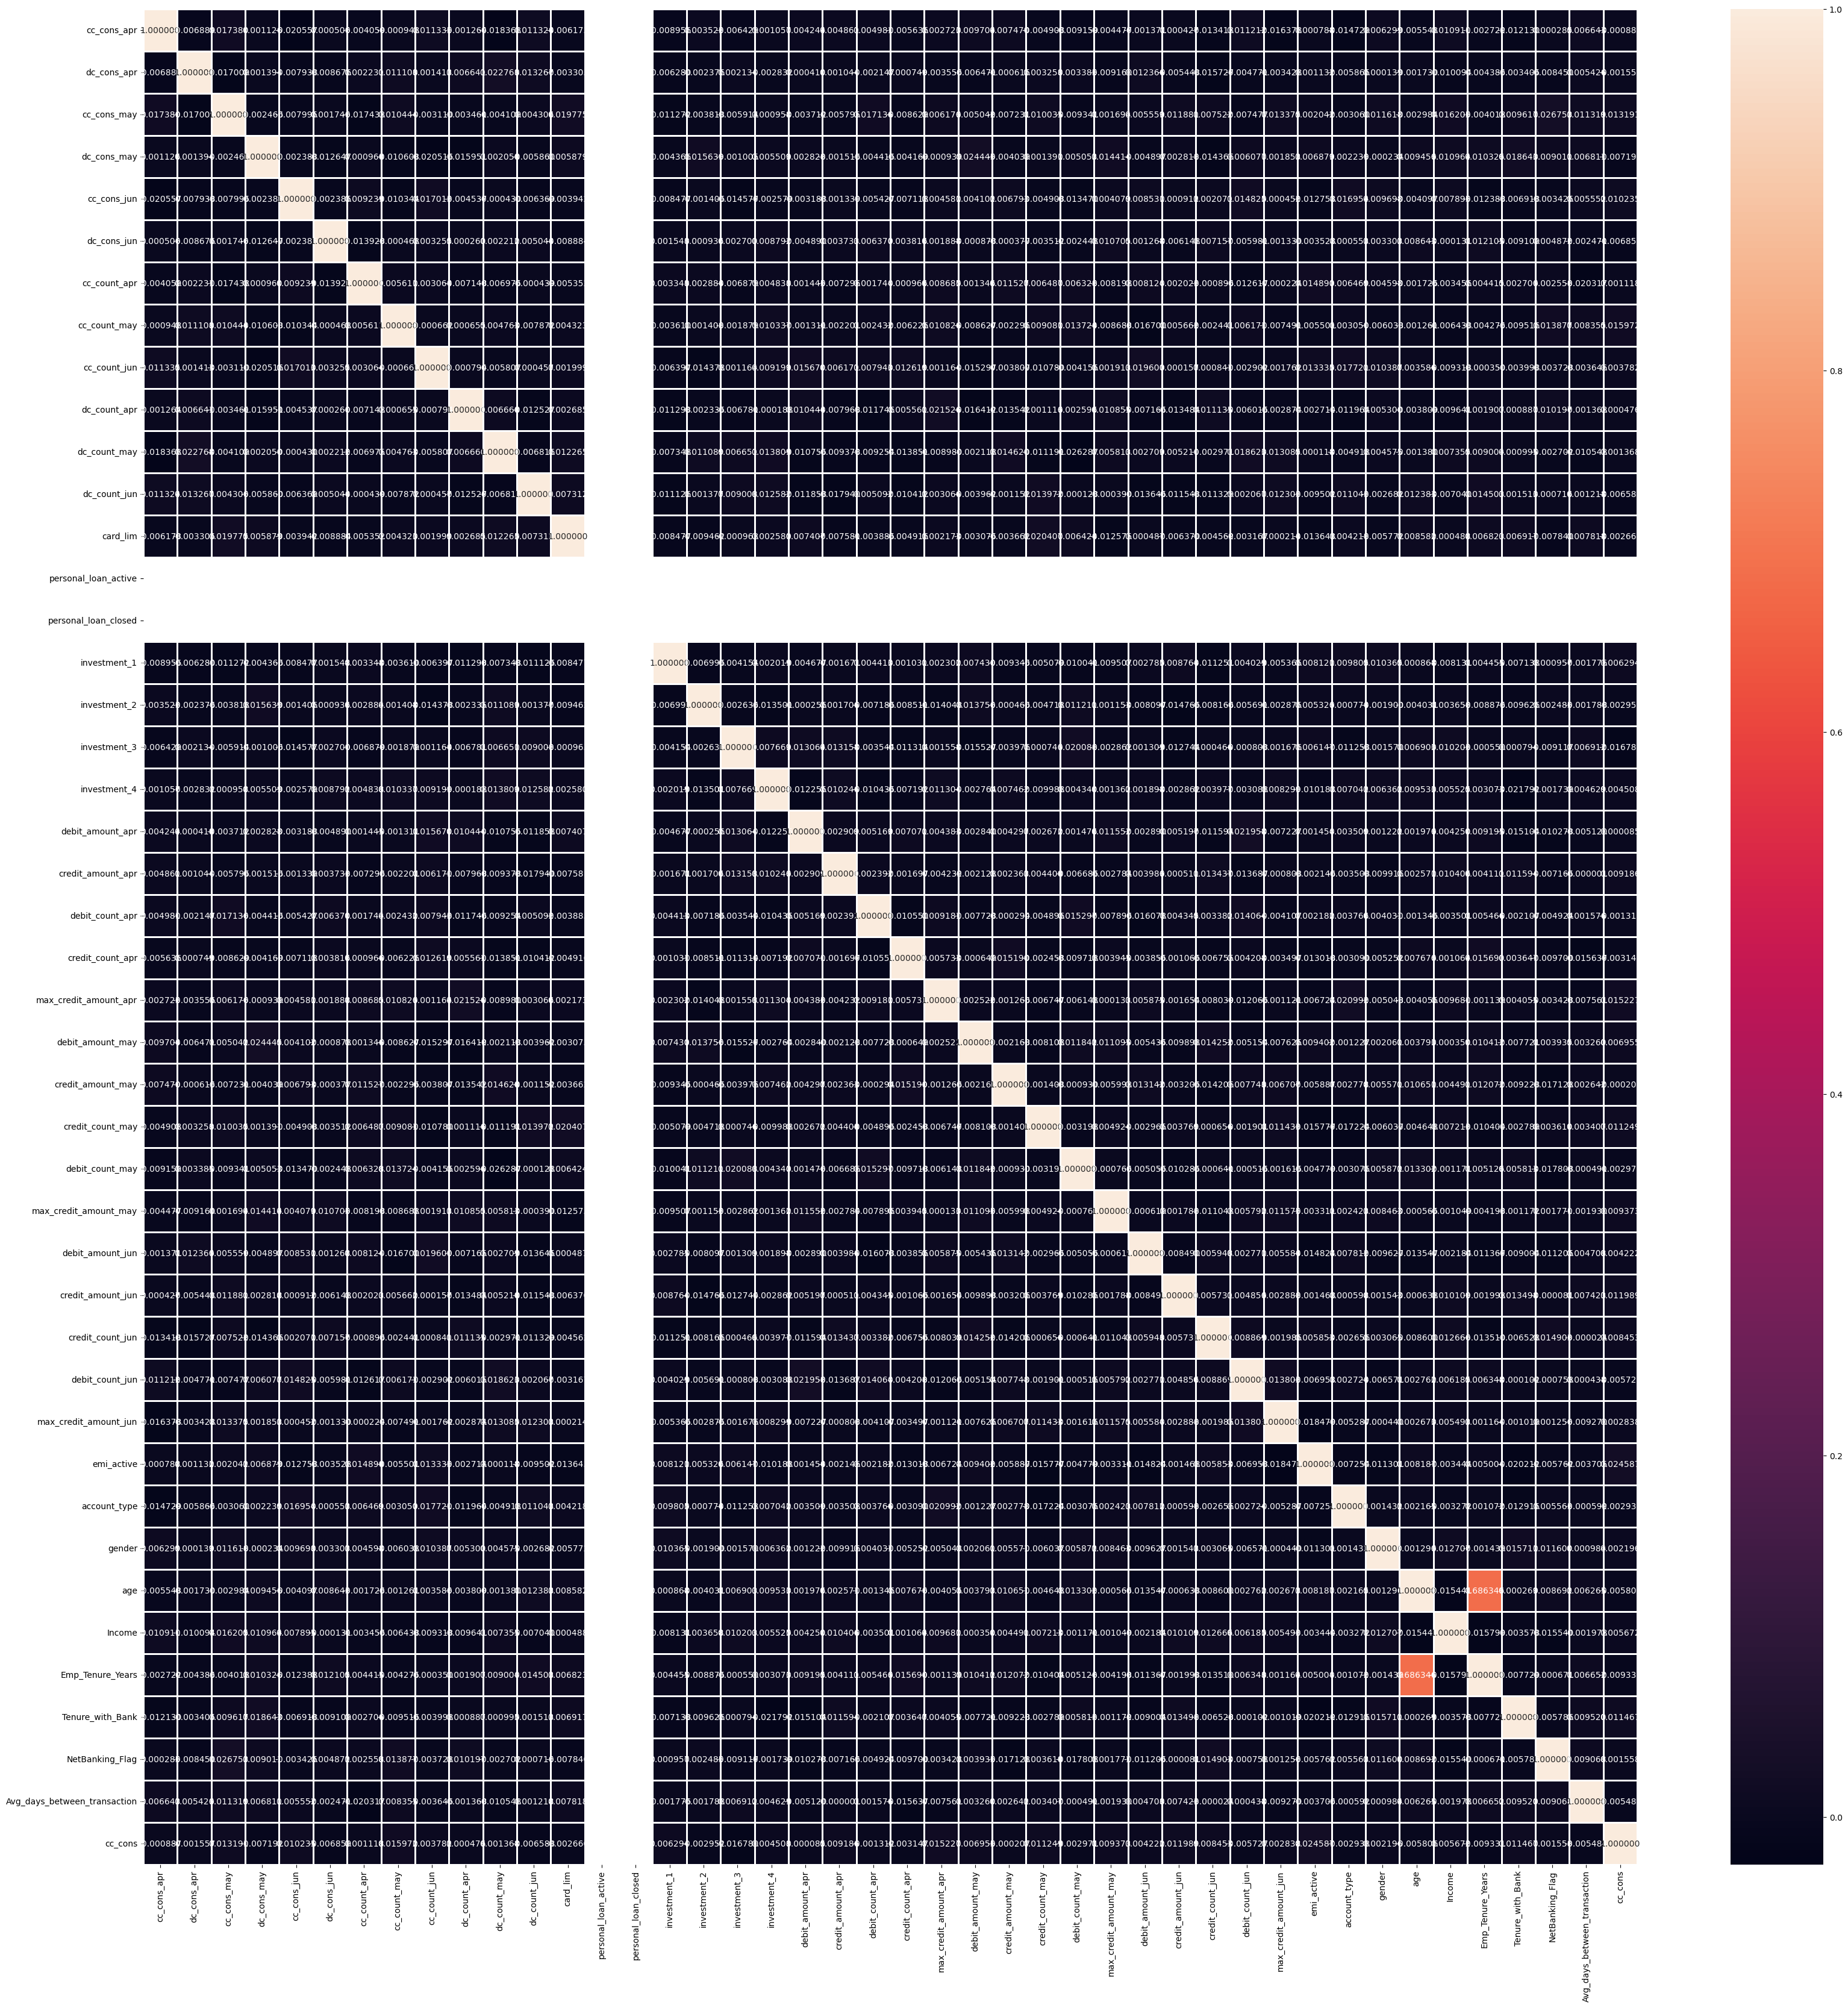

In [86]:
plt.figure(figsize= (40,40))
sns.heatmap(df.corr(), annot= True, fmt= '2f', linewidths= 2)

age and emp_tenure in years are highly correlated. Meaning if age is more the emp with bank is more.

In [87]:
df.personal_loan_active.value_counts()
df.personal_loan_closed.value_counts()

1.0    14995
Name: personal_loan_closed, dtype: int64

In [88]:
# doing same for df1
df1.personal_loan_active.value_counts()
df1.personal_loan_closed.value_counts()

1.0    4993
Name: personal_loan_closed, dtype: int64

In [89]:
# dropping these columns since they are having only one value
df.drop(columns= ['personal_loan_active','personal_loan_closed'], inplace= True)
df1.drop(columns= ['personal_loan_active','personal_loan_closed'], inplace= True)

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\761051921.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.drop(columns= ['personal_loan_active','personal_loan_closed'], inplace= True)


<Axes: >

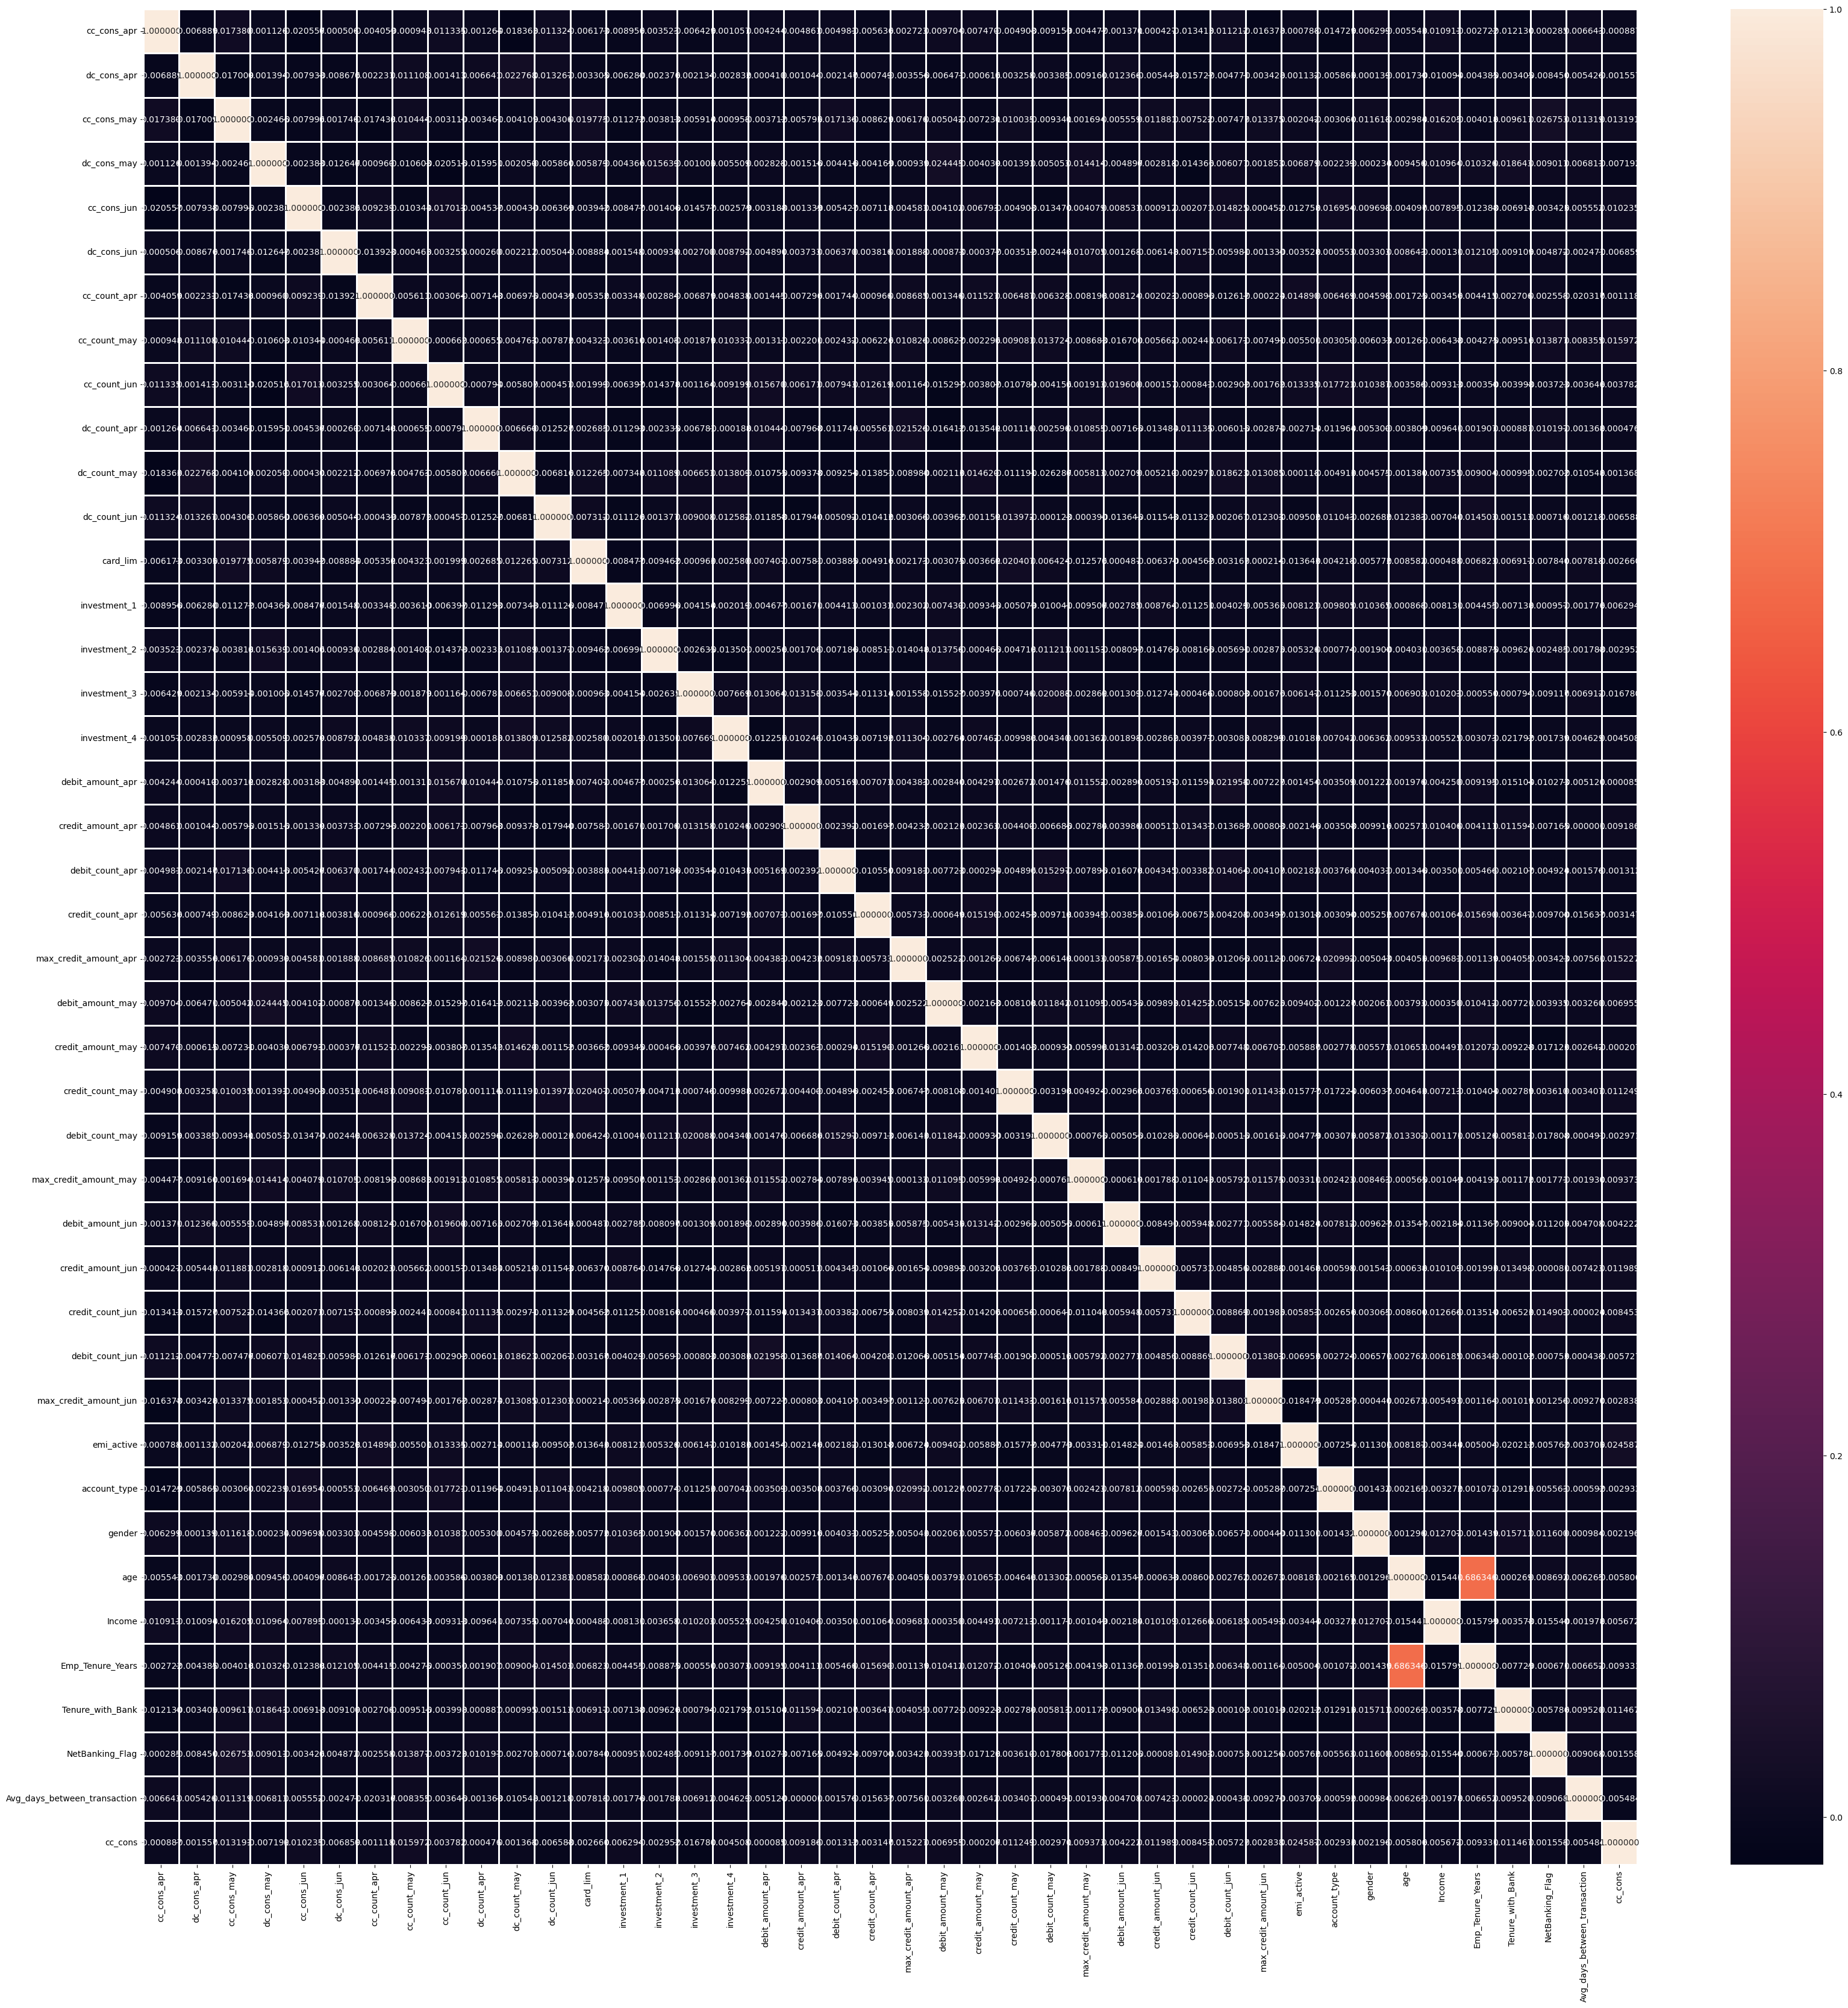

In [90]:
plt.figure(figsize= (40,40))
sns.heatmap(df.corr(), annot= True, fmt= '2f', linewidths= 2)

In [91]:
df.account_type.value_counts()

1    12722
0     2273
Name: account_type, dtype: int64

checking the plots between the variables and the dependant variable

In [92]:
# Creating the independant column names
x_col = df.columns.difference(['cc_cons'])
x_col

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income',
       'NetBanking_Flag', 'Tenure_with_Bank', 'account_type', 'age',
       'card_lim', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr',
       'cc_count_jun', 'cc_count_may', 'credit_amount_apr',
       'credit_amount_jun', 'credit_amount_may', 'credit_count_apr',
       'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun',
       'dc_cons_may', 'dc_count_apr', 'dc_count_jun', 'dc_count_may',
       'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may',
       'debit_count_apr', 'debit_count_jun', 'debit_count_may', 'emi_active',
       'gender', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun',
       'max_credit_amount_may'],
      dtype='object')

In [93]:
# Dependant variable
y_col = 'cc_cons'

<Figure size 1000x4000 with 0 Axes>

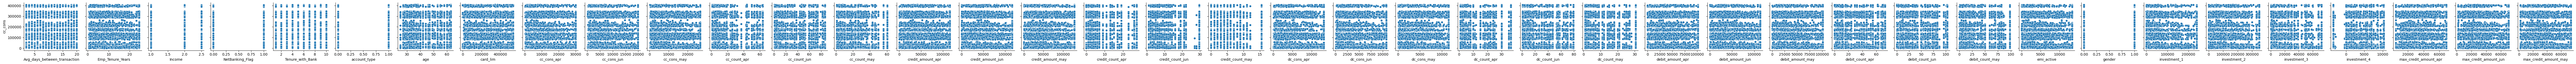

In [94]:
# plotting pair plots
plt.figure(figsize= (10,40))
sns.pairplot(df, x_vars= x_col, y_vars= y_col)

It appears that none of the independant variables is linearly varying with cc_cons(dependant variable)

In [95]:
# summing up the columns 
df["investment"]= df[['investment_1','investment_2','investment_3','investment_4']].sum(axis=1) 

# taking mean of the columns
df['cc_cons_old'] = df[['cc_cons_apr', 'cc_cons_may','cc_cons_jun']].mean(axis=1)
df['dc_cons'] = df[['dc_cons_apr', 'dc_cons_may','dc_cons_jun']].mean(axis=1)
df['cc_count'] = df[['cc_count_apr', 'cc_count_may','cc_count_jun']].mean(axis=1)
df['dc_count'] = df[['dc_count_apr', 'dc_count_may','dc_count_jun']].mean(axis=1)
df['debit_amount'] = df[['debit_amount_apr', 'debit_amount_may','debit_amount_jun']].mean(axis=1)
df['credit_amount'] = df[['credit_amount_apr', 'credit_amount_may','credit_amount_jun']].mean(axis=1)
df['max_credit_amount'] = df[['max_credit_amount_apr', 'max_credit_amount_may','max_credit_amount_jun']].mean(axis=1)
df['debit_count'] = df[['debit_count_apr', 'debit_count_may','debit_count_jun']].mean(axis=1)
df['credit_count'] = df[['credit_count_apr', 'credit_count_may','credit_count_jun']].mean(axis=1)

In [96]:
cols_to_delete = ['investment_1','investment_2','investment_3','investment_4','cc_cons_apr', 'cc_cons_may','cc_cons_jun',
                    'dc_cons_apr', 'dc_cons_may','dc_cons_jun','cc_count_apr', 'cc_count_may','cc_count_jun',
                    'dc_count_apr', 'dc_count_may','dc_count_jun','debit_amount_apr', 'debit_amount_may','debit_amount_jun',
                    'credit_amount_apr', 'credit_amount_may','credit_amount_jun',
                    'max_credit_amount_apr', 'max_credit_amount_may','max_credit_amount_jun','debit_count_apr',
                    'debit_count_may','debit_count_jun','credit_count_apr', 'credit_count_may','credit_count_jun']

In [97]:
# doing same for df1

# summing up the columns 
df1["investment"]= df1[['investment_1','investment_2','investment_3','investment_4']].sum(axis=1) 

# taking mean of the columns
df1['cc_cons_old'] = df1[['cc_cons_apr', 'cc_cons_may','cc_cons_jun']].mean(axis=1)
df1['dc_cons'] = df1[['dc_cons_apr', 'dc_cons_may','dc_cons_jun']].mean(axis=1)
df1['cc_count'] = df1[['cc_count_apr', 'cc_count_may','cc_count_jun']].mean(axis=1)
df1['dc_count'] = df1[['dc_count_apr', 'dc_count_may','dc_count_jun']].mean(axis=1)
df1['debit_amount'] = df1[['debit_amount_apr', 'debit_amount_may','debit_amount_jun']].mean(axis=1)
df1['credit_amount'] = df1[['credit_amount_apr', 'credit_amount_may','credit_amount_jun']].mean(axis=1)
df1['max_credit_amount'] = df1[['max_credit_amount_apr', 'max_credit_amount_may','max_credit_amount_jun']].mean(axis=1)
df1['debit_count'] = df1[['debit_count_apr', 'debit_count_may','debit_count_jun']].mean(axis=1)
df1['credit_count'] = df1[['credit_count_apr', 'credit_count_may','credit_count_jun']].mean(axis=1)

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\831562725.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["investment"]= df1[['investment_1','investment_2','investment_3','investment_4']].sum(axis=1)
C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\831562725.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cc_cons_old'] = df1[['cc_cons_apr', 'cc_cons_may','cc_cons_jun']].mean(axis=1)
C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\831562725.py:8: SettingWithCopyWarning: 
A value is tryi

In [98]:
df = df.drop(columns= cols_to_delete)
df1 = df1.drop(columns= cols_to_delete)

In [99]:
df.head()

card_lim  emi_active  account_type  gender  age  Income  Emp_Tenure_Years  \
0    358000     3448.84             1       1   30     2.0              7.00   
1    114000     3812.69             1       1   37     1.0             10.20   
2    360000     9432.90             1       1   33     2.0              3.90   
3    155000      144.61             1       1   63     1.0             24.45   
4    362000     1887.89             0       1   33     2.0              6.50   

   Tenure_with_Bank  NetBanking_Flag  Avg_days_between_transaction  ...  \
0                 5                1                          20.0  ...   
1                 8                1                           5.0  ...   
2                 3                1                          15.0  ...   
3                 6                0                          15.0  ...   
4                 7                0                           9.0  ...   

   investment   cc_cons_old      dc_cons   cc_count   dc_count  debit_amount  \
0   212976.70   3035.310000  4228.946667  10.333333  26.500000  38479.500000   
1   314178.00  14708.596667  5197.143333  21.666667   7.333333  48316.163333   
2   209702.60  11676.966667  4956.580000  36.500000  25.500000  40384.703333   
3   328747.00  16459.923333  4833.386667  10.000000  31.333333  68878.519167   
4    27653.23  11974.150000  1745.833333  29.666667  30.333333  37040.623333   

   credit_amount  max_credit_amount  debit_count  credit_count  
0   39339.790000       40821.166667    62.833333     10.166667  
1   31136.666667       23696.333333    31.000000     10.500000  
2   30454.666667       23906.666667    23.666667     16.000000  
3   43618.263333       59817.500000    26.666667     14.833333  
4   57242.166667       18873.666667    25.000000     10.500000  

[5 rows x 21 columns]

checking the smf values and filtering the required columns

In [100]:
x = df.drop(columns= ['cc_cons'])
y = df['cc_cons']

In [101]:
x.head()

card_lim  emi_active  account_type  gender  age  Income  Emp_Tenure_Years  \
0    358000     3448.84             1       1   30     2.0              7.00   
1    114000     3812.69             1       1   37     1.0             10.20   
2    360000     9432.90             1       1   33     2.0              3.90   
3    155000      144.61             1       1   63     1.0             24.45   
4    362000     1887.89             0       1   33     2.0              6.50   

   Tenure_with_Bank  NetBanking_Flag  Avg_days_between_transaction  \
0                 5                1                          20.0   
1                 8                1                           5.0   
2                 3                1                          15.0   
3                 6                0                          15.0   
4                 7                0                           9.0   

   investment   cc_cons_old      dc_cons   cc_count   dc_count  debit_amount  \
0   212976.70   3035.310000  4228.946667  10.333333  26.500000  38479.500000   
1   314178.00  14708.596667  5197.143333  21.666667   7.333333  48316.163333   
2   209702.60  11676.966667  4956.580000  36.500000  25.500000  40384.703333   
3   328747.00  16459.923333  4833.386667  10.000000  31.333333  68878.519167   
4    27653.23  11974.150000  1745.833333  29.666667  30.333333  37040.623333   

   credit_amount  max_credit_amount  debit_count  credit_count  
0   39339.790000       40821.166667    62.833333     10.166667  
1   31136.666667       23696.333333    31.000000     10.500000  
2   30454.666667       23906.666667    23.666667     16.000000  
3   43618.263333       59817.500000    26.666667     14.833333  
4   57242.166667       18873.666667    25.000000     10.500000

In [102]:
y.head()

0    13434.0
1      449.0
2    11968.0
3    32029.0
4    16394.0
Name: cc_cons, dtype: float64

In [103]:
# adding constant term to dependant variable
x_with_cont =sm.add_constant(x)

In [104]:
x_with_cont

const  card_lim  emi_active  account_type  gender  age  Income  \
0        1.0    358000     3448.84             1       1   30     2.0   
1        1.0    114000     3812.69             1       1   37     1.0   
2        1.0    360000     9432.90             1       1   33     2.0   
3        1.0    155000      144.61             1       1   63     1.0   
4        1.0    362000     1887.89             0       1   33     2.0   
...      ...       ...         ...           ...     ...  ...     ...   
14995    1.0    520000    13289.91             1       0   53     1.0   
14996    1.0    472000     4762.10             1       1   44     2.0   
14997    1.0     44000     2877.33             1       1   37     2.0   
14998    1.0    359000    13006.84             1       1   63     2.0   
14999    1.0    256000     1588.60             1       1   63     2.0   

       Emp_Tenure_Years  Tenure_with_Bank  NetBanking_Flag  ...  investment  \
0                  7.00                 5                1  ...   212976.70   
1                 10.20                 8                1  ...   314178.00   
2                  3.90                 3                1  ...   209702.60   
3                 24.45                 6                0  ...   328747.00   
4                  6.50                 7                0  ...    27653.23   
...                 ...               ...              ...  ...         ...   
14995             13.20                 9                1  ...   227381.00   
14996              2.40                 9                1  ...   254726.50   
14997              3.40                 9                1  ...   468825.02   
14998             24.45                10                1  ...   588452.00   
14999              4.60                 2                0  ...    83332.24   

        cc_cons_old      dc_cons   cc_count   dc_count  debit_amount  \
0       3035.310000  4228.946667  10.333333  26.500000  38479.500000   
1      14708.596667  5197.143333  21.666667   7.333333  48316.163333   
2      11676.966667  4956.580000  36.500000  25.500000  40384.703333   
3      16459.923333  4833.386667  10.000000  31.333333  68878.519167   
4      11974.150000  1745.833333  29.666667  30.333333  37040.623333   
...             ...          ...        ...        ...           ...   
14995   8109.666667  5066.283333  14.000000  32.000000  58301.572500   
14996  16042.970000  4919.866667  13.000000   3.333333  35495.900000   
14997  14459.163333  1081.503333  47.000000  10.000000  50942.286667   
14998  25460.614167  6565.766667  37.166667   4.333333  56734.244167   
14999  11034.470000  2424.066667  32.833333  27.666667  68004.790000   

       credit_amount  max_credit_amount  debit_count  credit_count  
0       39339.790000       40821.166667    62.833333     10.166667  
1       31136.666667       23696.333333    31.000000     10.500000  
2       30454.666667       23906.666667    23.666667     16.000000  
3       43618.263333       59817.500000    26.666667     14.833333  
4       57242.166667       18873.666667    25.000000     10.500000  
...              ...                ...          ...           ...  
14995   32484.166667       34944.916667    29.500000      5.666667  
14996   36269.183333       58246.750000    27.000000      5.666667  
14997   82216.820833       45017.000000    27.333333      6.833333  
14998   58287.430000       19216.333333    36.000000     11.166667  
14999   74828.166667       33143.333333    62.333333     12.166667  

[14995 rows x 21 columns]

In [105]:
vif_table=pd.DataFrame()
vif_table['Features'] = x_with_cont.columns
vif_table['VIF']= [variance_inflation_factor(x_with_cont,i) for i in range (x_with_cont.shape[1])]

In [106]:
vif_table

Features         VIF
0                          const  103.626924
1                       card_lim    1.000977
2                     emi_active    1.001746
3                   account_type    1.000861
4                         gender    1.001058
5                            age    1.891595
6                         Income    1.001733
7               Emp_Tenure_Years    1.891989
8               Tenure_with_Bank    1.001768
9                NetBanking_Flag    1.001595
10  Avg_days_between_transaction    1.000851
11                    investment    1.001210
12                   cc_cons_old    1.001854
13                       dc_cons    1.000706
14                      cc_count    1.001099
15                      dc_count    1.001920
16                  debit_amount    1.001355
17                 credit_amount    1.001359
18             max_credit_amount    1.001088
19                   debit_count    1.000422
20                  credit_count    1.001111

In [107]:
vif_table = vif_table.loc[vif_table.VIF<5]

In [108]:
vif_table.Features.values

array(['card_lim', 'emi_active', 'account_type', 'gender', 'age',
       'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank',
       'NetBanking_Flag', 'Avg_days_between_transaction', 'investment',
       'cc_cons_old', 'dc_cons', 'cc_count', 'dc_count', 'debit_amount',
       'credit_amount', 'max_credit_amount', 'debit_count',
       'credit_count'], dtype=object)

In [109]:
df.head()

card_lim  emi_active  account_type  gender  age  Income  Emp_Tenure_Years  \
0    358000     3448.84             1       1   30     2.0              7.00   
1    114000     3812.69             1       1   37     1.0             10.20   
2    360000     9432.90             1       1   33     2.0              3.90   
3    155000      144.61             1       1   63     1.0             24.45   
4    362000     1887.89             0       1   33     2.0              6.50   

   Tenure_with_Bank  NetBanking_Flag  Avg_days_between_transaction  ...  \
0                 5                1                          20.0  ...   
1                 8                1                           5.0  ...   
2                 3                1                          15.0  ...   
3                 6                0                          15.0  ...   
4                 7                0                           9.0  ...   

   investment   cc_cons_old      dc_cons   cc_count   dc_count  debit_amount  \
0   212976.70   3035.310000  4228.946667  10.333333  26.500000  38479.500000   
1   314178.00  14708.596667  5197.143333  21.666667   7.333333  48316.163333   
2   209702.60  11676.966667  4956.580000  36.500000  25.500000  40384.703333   
3   328747.00  16459.923333  4833.386667  10.000000  31.333333  68878.519167   
4    27653.23  11974.150000  1745.833333  29.666667  30.333333  37040.623333   

   credit_amount  max_credit_amount  debit_count  credit_count  
0   39339.790000       40821.166667    62.833333     10.166667  
1   31136.666667       23696.333333    31.000000     10.500000  
2   30454.666667       23906.666667    23.666667     16.000000  
3   43618.263333       59817.500000    26.666667     14.833333  
4   57242.166667       18873.666667    25.000000     10.500000  

[5 rows x 21 columns]

In [110]:
# we are taking every column into consideration since VIF for all the columns are not exceeding the threshold of 5

here the credit card consumption is based on the above columns so we wil take only these columns

In [111]:
# VIF of all the columns is less than 5. so, we will keep all the columns.
# This shows every column is adding explanation for the dependant column cc_cons

In [112]:
df.shape

(14995, 21)

In [113]:
X = df.drop(columns= ['cc_cons'])
y = df['cc_cons']

In [166]:
# function to calculate root mean squared percentage error
def rmspe(y_true, y_pred):
    y_true != 0
    rmspe = np.sqrt(np.mean(np.square((y_true-y_pred)/y_true)*100))
    
    return rmspe


## Training the model

we need to split the dataset df, scale independant variables , make skewness of dependant variable between -0.5 and 0.5, train our models and optimize it .
we will create a pipeline for all the steps

In [115]:
# Splitting the data into train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [116]:
X_train

card_lim  emi_active  account_type  gender  age  Income  \
10808    100000      456.99             0       1   32     2.0   
13985    329000     4500.13             1       1   47     2.0   
13949    538000     4162.96             1       1   63     1.0   
9689     467000    12645.31             0       1   30     2.0   
10330    100000     6452.71             1       1   35     2.0   
...         ...         ...           ...     ...  ...     ...   
5196     538000    10815.90             0       1   49     2.0   
13423    375000    13289.91             1       1   27     2.0   
5395     538000    13289.91             1       1   63     2.0   
860      524000     1553.16             1       0   32     1.0   
7275     471000     1570.29             0       1   35     1.0   

       Emp_Tenure_Years  Tenure_with_Bank  NetBanking_Flag  \
10808              10.8                 5                1   
13985               2.7                 6                1   
13949               4.6                 3                1   
9689                8.0                 6                1   
10330               4.5                 2                0   
...                 ...               ...              ...   
5196               23.2                 1                1   
13423               0.7                 4                1   
5395               13.8                10                0   
860                 9.6                 3                0   
7275               12.0                 6                1   

       Avg_days_between_transaction  investment   cc_cons_old      dc_cons  \
10808                          19.0   311473.62  14522.596667  5515.426667   
13985                          17.0   223680.00  18717.616667  5862.510000   
13949                          16.0   123996.69  12946.983333  1042.676667   
9689                           12.0   530090.05   4890.563333  4461.670000   
10330                           8.0   489989.81  23732.864167  6062.240000   
...                             ...         ...           ...          ...   
5196                            2.0   429175.00  10330.140000  2784.840000   
13423                           4.0    99933.60   2149.736667  5011.980000   
5395                            8.0   149139.55  16198.778333  7138.933333   
860                            14.0   117077.00  12744.676667  5004.843333   
7275                            5.0    76018.61  17122.916667  7142.083333   

        cc_count   dc_count  debit_amount  credit_amount  max_credit_amount  \
10808  11.666667  12.166667  50695.920000   51505.000000       39798.250000   
13985  28.500000  12.833333  46946.220833   31730.500000       26448.000000   
13949  42.666667  31.666667  30022.100000   49131.930000       33342.833333   
9689   16.333333   5.000000  84927.966667   26201.666667       53269.333333   
10330  24.833333  16.333333  66013.560000   76903.576667       22573.136667   
...          ...        ...           ...            ...                ...   
5196   10.000000  11.333333  52390.306667   47176.166667       28876.000000   
13423  32.666667  15.500000  59051.813333   59145.000000       28439.430000   
5395   25.666667  21.666667  24237.183333   50482.500000       31646.333333   
860    45.833333  28.000000  26858.140000   98004.397500       45920.916667   
7275   18.666667  11.666667  56249.910000   47267.166667       50032.833333   

       debit_count  credit_count  
10808    11.000000      9.833333  
13985    16.333333     10.333333  
13949     7.666667      3.666667  
9689     33.333333     12.166667  
10330    27.666667      3.666667  
...            ...           ...  
5196     21.666667      9.666667  
13423    61.500000     10.666667  
5395     34.666667      5.666667  
860      26.000000      2.000000  
7275     36.000000     15.666667  

[10046 rows x 20 columns]

In [117]:
X_test

card_lim  emi_active  account_type  gender  age  Income  \
13415    366000      196.96             1       1   31     1.0   
6477     267000      366.78             1       1   32     2.0   
9972     212500    13289.91             1       0   42     2.0   
862       28000     1320.12             0       1   37     1.0   
5972      87000      518.29             0       1   63     1.0   
...         ...         ...           ...     ...  ...     ...   
6893     520000     1376.83             0       1   62     2.0   
10158    353000      864.24             1       0   35     2.5   
13355    272000     4217.66             1       1   63     1.0   
655      138000     2665.14             0       1   53     2.0   
13682    232000    13289.91             0       1   55     2.0   

       Emp_Tenure_Years  Tenure_with_Bank  NetBanking_Flag  \
13415              4.40                 1                1   
6477               9.60                 5                1   
9972               8.80                 4                1   
862                1.70                 5                1   
5972              24.45                10                1   
...                 ...               ...              ...   
6893              24.45                 2                1   
10158              9.00                 2                1   
13355             24.45                 4                1   
655               19.80                 5                1   
13682             24.45                 6                1   

       Avg_days_between_transaction  investment   cc_cons_old      dc_cons  \
13415                           8.0    48257.95  18020.236667  9609.250000   
6477                           19.0   232636.90  14923.720000  2613.590000   
9972                            6.0   133901.96   4489.791667  3699.810000   
862                             3.0   112562.50  17137.072500  9473.626667   
5972                            8.0   642920.50   7158.553333  6328.083333   
...                             ...         ...           ...          ...   
6893                           10.0   422643.80   7570.416667  4529.636667   
10158                           3.0   155305.00  11296.894167  9135.916667   
13355                           3.0   299958.91  23404.905833  3271.183333   
655                             8.0   411476.00   8414.743333  3994.000000   
13682                          14.0   280646.40  11333.650000  3296.680000   

        cc_count   dc_count  debit_amount  credit_amount  max_credit_amount  \
13415  26.666667  12.333333  70876.353333   47244.000000       49339.333333   
6477   25.333333   1.333333  61363.826667  109303.150833       13988.666667   
9972   36.166667  29.000000  29066.003333   87761.166667       53579.166667   
862    12.333333  17.333333  35564.173333   23064.333333       17093.000000   
5972   33.166667  16.333333  68822.703333   39885.536667       26486.666667   
...          ...        ...           ...            ...                ...   
6893   43.500000  30.833333  21260.253333   33030.086667       28899.583333   
10158  12.333333  21.833333  18789.816667   81632.166667       26018.000000   
13355  26.000000  16.333333  63778.430833   81930.215000       30276.666667   
655     5.333333  16.000000  68523.370000   27526.166667       43642.166667   
13682  25.166667  13.333333  43278.986667   51340.626667       38859.000000   

       debit_count  credit_count  
13415    56.666667      6.500000  
6477     37.833333     15.000000  
9972     71.833333      7.833333  
862      24.666667     16.666667  
5972     73.500000      4.666667  
...            ...           ...  
6893     72.833333     19.666667  
10158    21.000000     19.166667  
13355    29.000000      8.000000  
655      12.333333     24.166667  
13682    30.666667     13.166667  

[4949 rows x 20 columns]

In [118]:
y_train

10808       860.0
13985     18431.0
13949     14481.0
9689     303912.0
10330     15781.0
           ...   
5196       6512.0
13423     15703.0
5395      27966.0
860      102117.0
7275        600.0
Name: cc_cons, Length: 10046, dtype: float64

In [119]:
y_test

13415      7426.0
6477     106953.0
9972       2950.0
862        3841.0
5972      16357.0
           ...   
6893     343429.0
10158    292435.0
13355    171814.0
655        1545.0
13682      4577.0
Name: cc_cons, Length: 4949, dtype: float64

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\1133203749.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train), y_train.skew()


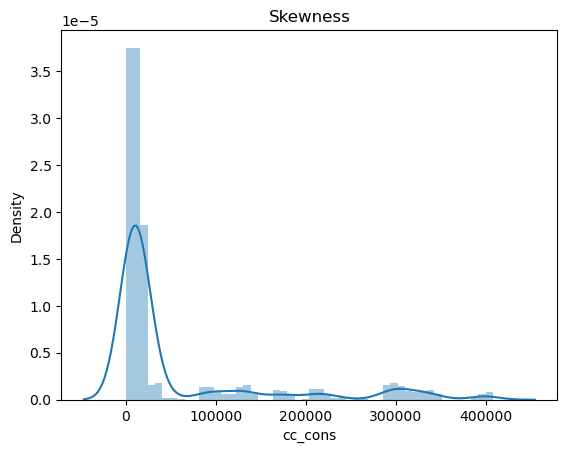

In [120]:
sns.distplot(y_train), y_train.skew()
plt.title('Skewness')
plt.show()

The data is positively skewed so we will change it to make skewness between -0.5 to 0.5

C:\Users\pauld\AppData\Local\Temp\ipykernel_12440\3947538725.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train**0.05)


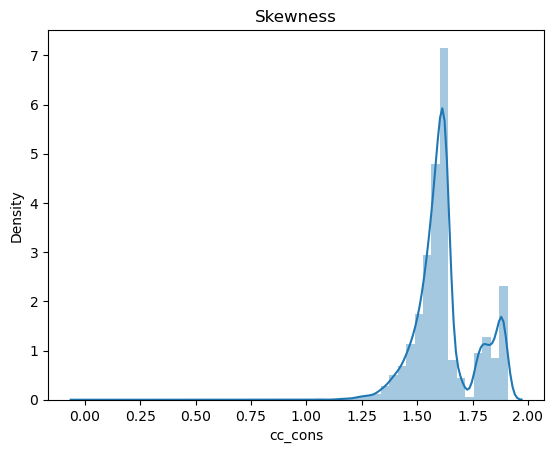

In [121]:
sns.distplot(y_train**0.05)
plt.title('Skewness')
plt.show()

In [122]:
(y_train**0.05).skew()

0.18693400924505452

In [123]:
# we will use this as y_train

In [124]:
y_train = y_train**0.05
y_test = y_test**0.05

In [125]:
# we will raise the predicted values by 20 to get original results

## Linear Regression

In [126]:
pipe1 = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('Linear_regression', LinearRegression())   #step 2: Model fitting
            ])

In [127]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('Linear_regression', LinearRegression())])

In [128]:
pipe1.predict(X_test)

array([1.62326601, 1.62529359, 1.62789643, ..., 1.62977   , 1.62551796,
       1.63235188])

In [168]:
rmspe(y_test**20,pipe1.predict(X_test)**20)

292.87765158588945

## KNN regression

In [130]:
pipe2 = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('KNN_Regressor', KNeighborsRegressor())   #step 2: Model fitting
            ])

In [131]:
param_grid_pipe2 = {
    'KNN_Regressor__n_neighbors': [1, 2, 4, 6, 8, 12, 20],
    'KNN_Regressor__weights': ['uniform', 'distance'],
    'KNN_Regressor__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'KNN_Regressor__p': [1, 2, 3],  #for minkowski distance
}

grid_search = GridSearchCV(estimator= pipe2, param_grid=param_grid_pipe2)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_Regressor',
                                        KNeighborsRegressor())]),
             param_grid={'KNN_Regressor__algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                         'KNN_Regressor__n_neighbors': [1, 2, 4, 6, 8, 12, 20],
                         'KNN_Regressor__p': [1, 2, 3],
                         'KNN_Regressor__weights': ['uniform', 'distance']})

In [132]:
grid_search.best_params_

{'KNN_Regressor__algorithm': 'auto',
 'KNN_Regressor__n_neighbors': 20,
 'KNN_Regressor__p': 3,
 'KNN_Regressor__weights': 'uniform'}

In [133]:
# for better evaluation changing the parameters near the best fit
param_grid_pipe2 = {
    'KNN_Regressor__n_neighbors': [15,18,20,22,24,26,30,50,80],
    'KNN_Regressor__weights': ['uniform'],
    'KNN_Regressor__algorithm': ['auto'],
    'KNN_Regressor__p': [3,4,5],  
}

grid_search = GridSearchCV(estimator= pipe2, param_grid=param_grid_pipe2)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_Regressor',
                                        KNeighborsRegressor())]),
             param_grid={'KNN_Regressor__algorithm': ['auto'],
                         'KNN_Regressor__n_neighbors': [15, 18, 20, 22, 24, 26,
                                                        30, 50, 80],
                         'KNN_Regressor__p': [3, 4, 5],
                         'KNN_Regressor__weights': ['uniform']})

In [136]:
grid_search.best_params_

{'KNN_Regressor__algorithm': 'auto',
 'KNN_Regressor__n_neighbors': 80,
 'KNN_Regressor__p': 4,
 'KNN_Regressor__weights': 'uniform'}

In [142]:
# for better evaluation changing the parameters near the best fit
param_grid_pipe2 = {
    'KNN_Regressor__n_neighbors': [60,70,80,90,100,110,120,130,140,150],
    'KNN_Regressor__weights': ['uniform'],
    'KNN_Regressor__algorithm': ['auto'],
    'KNN_Regressor__p': [3],  
}

grid_search = GridSearchCV(estimator= pipe2, param_grid=param_grid_pipe2)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_Regressor',
                                        KNeighborsRegressor())]),
             param_grid={'KNN_Regressor__algorithm': ['auto'],
                         'KNN_Regressor__n_neighbors': [60, 70, 80, 90, 100,
                                                        110, 120, 130, 140,
                                                        150],
                         'KNN_Regressor__p': [3, 4, 5],
                         'KNN_Regressor__weights': ['uniform']})

In [143]:
grid_search.best_params_

{'KNN_Regressor__algorithm': 'auto',
 'KNN_Regressor__n_neighbors': 150,
 'KNN_Regressor__p': 5,
 'KNN_Regressor__weights': 'uniform'}

In [146]:
# for better evaluation changing the parameters near the best fit
param_grid_pipe2 = {
    'KNN_Regressor__n_neighbors': [150,200,250,300,350,400,450,500],
    'KNN_Regressor__weights': ['uniform'],
    'KNN_Regressor__algorithm': ['auto'],
    'KNN_Regressor__p': [3],  
}

grid_search = GridSearchCV(estimator= pipe2, param_grid=param_grid_pipe2)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_Regressor',
                                        KNeighborsRegressor())]),
             param_grid={'KNN_Regressor__algorithm': ['auto'],
                         'KNN_Regressor__n_neighbors': [150, 200, 250, 300, 350,
                                                        400, 450, 500],
                         'KNN_Regressor__p': [3],
                         'KNN_Regressor__weights': ['uniform']})

In [147]:
grid_search.best_params_

{'KNN_Regressor__algorithm': 'auto',
 'KNN_Regressor__n_neighbors': 500,
 'KNN_Regressor__p': 3,
 'KNN_Regressor__weights': 'uniform'}

In [150]:
# for better evaluation changing the parameters near the best fit
param_grid_pipe2 = {
    'KNN_Regressor__n_neighbors': [500,700,900,1100,1300],
    'KNN_Regressor__weights': ['uniform'],
    'KNN_Regressor__algorithm': ['auto'],
    'KNN_Regressor__p': [3],  
}

grid_search = GridSearchCV(estimator= pipe2, param_grid=param_grid_pipe2)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_Regressor',
                                        KNeighborsRegressor())]),
             param_grid={'KNN_Regressor__algorithm': ['auto'],
                         'KNN_Regressor__n_neighbors': [500, 700, 900, 1100,
                                                        1300],
                         'KNN_Regressor__p': [3],
                         'KNN_Regressor__weights': ['uniform']})

In [151]:
grid_search.best_params_

{'KNN_Regressor__algorithm': 'auto',
 'KNN_Regressor__n_neighbors': 1300,
 'KNN_Regressor__p': 3,
 'KNN_Regressor__weights': 'uniform'}

In [154]:
# for better evaluation changing the parameters near the best fit
param_grid_pipe2 = {
    'KNN_Regressor__n_neighbors': [1300,1500,2000,2500,3000],
    'KNN_Regressor__weights': ['uniform'],
    'KNN_Regressor__algorithm': ['auto'],
    'KNN_Regressor__p': [3],  
}

grid_search = GridSearchCV(estimator= pipe2, param_grid=param_grid_pipe2)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_Regressor',
                                        KNeighborsRegressor())]),
             param_grid={'KNN_Regressor__algorithm': ['auto'],
                         'KNN_Regressor__n_neighbors': [1300, 1500, 2000, 2500,
                                                        3000],
                         'KNN_Regressor__p': [3],
                         'KNN_Regressor__weights': ['uniform']})

In [155]:
grid_search.best_params_

{'KNN_Regressor__algorithm': 'auto',
 'KNN_Regressor__n_neighbors': 1300,
 'KNN_Regressor__p': 3,
 'KNN_Regressor__weights': 'uniform'}

In [170]:
# for better evaluation changing the parameters near the best fit
param_grid_pipe2 = {
    'KNN_Regressor__n_neighbors': [1250,1260,1270,1280,1290,1300,1310,1320,1330,1340],
    'KNN_Regressor__weights': ['uniform'],
    'KNN_Regressor__algorithm': ['auto'],
    'KNN_Regressor__p': [3],  
}

grid_search = GridSearchCV(estimator= pipe2, param_grid=param_grid_pipe2)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN_Regressor',
                                        KNeighborsRegressor())]),
             param_grid={'KNN_Regressor__algorithm': ['auto'],
                         'KNN_Regressor__n_neighbors': [1250, 1260, 1270, 1280,
                                                        1290, 1300, 1310, 1320,
                                                        1330, 1340],
                         'KNN_Regressor__p': [3],
                         'KNN_Regressor__weights': ['uniform']})

In [171]:
grid_search.best_params_

{'KNN_Regressor__algorithm': 'auto',
 'KNN_Regressor__n_neighbors': 1270,
 'KNN_Regressor__p': 3,
 'KNN_Regressor__weights': 'uniform'}

In [152]:
pipe2_best = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('KNN_Regressor', KNeighborsRegressor(n_neighbors= 1270, p= 3, weights= 'uniform'))   #step 2: Model fitting
            ])

In [172]:
pipe2_best.fit(X_train, y_train)
rmspe(y_test**20,pipe2_best.predict(X_test)**20)

291.2985139173693

## Random forest regressor

In [182]:
pipe3 = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('Random_forest', RandomForestRegressor())   #step 2: Model fitting
            ])

In [185]:
param_grid_pipe3 = {
    'Random_forest__n_estimators': [10, 50, 100],
    'Random_forest__max_depth': [6,7,8,9],
    'Random_forest__min_samples_leaf': [10,40,100,],
    'Random_forest__max_leaf_nodes': [20,40,80],  
}

grid_search = GridSearchCV(estimator= pipe3, param_grid=param_grid_pipe3)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Random_forest',
                                        RandomForestRegressor())]),
             param_grid={'Random_forest__max_depth': [6, 7, 8, 9],
                         'Random_forest__max_leaf_nodes': [20, 40, 80],
                         'Random_forest__min_samples_leaf': [10, 40, 100],
                         'Random_forest__n_estimators': [10, 50, 100]})

In [186]:
grid_search.best_params_

{'Random_forest__max_depth': 8,
 'Random_forest__max_leaf_nodes': 20,
 'Random_forest__min_samples_leaf': 10,
 'Random_forest__n_estimators': 100}

In [187]:
param_grid_pipe3 = {
    'Random_forest__n_estimators': [80,100,150,300],
    'Random_forest__max_depth': [8],
    'Random_forest__min_samples_leaf': [10],
    'Random_forest__max_leaf_nodes': [20],  
}

grid_search = GridSearchCV(estimator= pipe3, param_grid=param_grid_pipe3)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Random_forest',
                                        RandomForestRegressor())]),
             param_grid={'Random_forest__max_depth': [8],
                         'Random_forest__max_leaf_nodes': [20],
                         'Random_forest__min_samples_leaf': [10],
                         'Random_forest__n_estimators': [80, 100, 150, 300]})

In [188]:
grid_search.best_params_

{'Random_forest__max_depth': 8,
 'Random_forest__max_leaf_nodes': 20,
 'Random_forest__min_samples_leaf': 10,
 'Random_forest__n_estimators': 150}

In [189]:
param_grid_pipe3 = {
    'Random_forest__n_estimators': [120, 150, 180],
    'Random_forest__max_depth': [8],
    'Random_forest__min_samples_leaf': [10],
    'Random_forest__max_leaf_nodes': [20],  
}

grid_search = GridSearchCV(estimator= pipe3, param_grid=param_grid_pipe3)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Random_forest',
                                        RandomForestRegressor())]),
             param_grid={'Random_forest__max_depth': [8],
                         'Random_forest__max_leaf_nodes': [20],
                         'Random_forest__min_samples_leaf': [10],
                         'Random_forest__n_estimators': [120, 150, 180]})

In [190]:
grid_search.best_params_

{'Random_forest__max_depth': 8,
 'Random_forest__max_leaf_nodes': 20,
 'Random_forest__min_samples_leaf': 10,
 'Random_forest__n_estimators': 150}

In [191]:
param_grid_pipe3 = {
    'Random_forest__n_estimators': [140, 150, 160],
    'Random_forest__max_depth': [8],
    'Random_forest__min_samples_leaf': [10],
    'Random_forest__max_leaf_nodes': [20],  
}

grid_search = GridSearchCV(estimator= pipe3, param_grid=param_grid_pipe3)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('Random_forest',
                                        RandomForestRegressor())]),
             param_grid={'Random_forest__max_depth': [8],
                         'Random_forest__max_leaf_nodes': [20],
                         'Random_forest__min_samples_leaf': [10],
                         'Random_forest__n_estimators': [140, 150, 160]})

In [192]:
grid_search.best_params_

{'Random_forest__max_depth': 8,
 'Random_forest__max_leaf_nodes': 20,
 'Random_forest__min_samples_leaf': 10,
 'Random_forest__n_estimators': 150}

In [194]:
pipe3_best = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('Random_forest', RandomForestRegressor(max_depth=8, max_leaf_nodes= 20, min_samples_leaf=10, n_estimators = 150))   #step 2: Model fitting
            ])

In [198]:
pipe3_best.fit(X_train, y_train)
rmspe(y_test**20,pipe3_best.predict(X_test)**20)

292.93962421313023

In [196]:
# The rmspe is nearly same as that from KNN. We will try some boosting techniques now and compare the results

## Adaboost

In [217]:
pipe4 = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('adaboost', AdaBoostRegressor())   #step 2: Model fitting
            ])

In [218]:
param_grid_pipe4 = {
    'adaboost__n_estimators': [1,10,50,100,500], 
    'adaboost__learning_rate': [0.05, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(estimator= pipe4, param_grid=param_grid_pipe4)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('adaboost', AdaBoostRegressor())]),
             param_grid={'adaboost__learning_rate': [0.05, 0.1, 0.2, 0.3],
                         'adaboost__n_estimators': [1, 10, 50, 100, 500]})

In [219]:
grid_search.best_params_

{'adaboost__learning_rate': 0.05, 'adaboost__n_estimators': 10}

In [220]:
param_grid_pipe4 = {
    'adaboost__n_estimators': [8,9,10,11,12,15,20], 
    'adaboost__learning_rate': [0.05]
}

grid_search = GridSearchCV(estimator= pipe4, param_grid=param_grid_pipe4)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('adaboost', AdaBoostRegressor())]),
             param_grid={'adaboost__learning_rate': [0.05],
                         'adaboost__n_estimators': [8, 9, 10, 11, 12, 15, 20]})

In [221]:
grid_search.best_params_

{'adaboost__learning_rate': 0.05, 'adaboost__n_estimators': 10}

In [222]:
pipe4_best = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('adaboost', AdaBoostRegressor(learning_rate=0.05, n_estimators= 10))   #step 2: Model fitting
            ])

In [223]:
pipe4_best.fit(X_train, y_train)
rmspe(y_test**20,pipe4_best.predict(X_test)**20)

293.5372025004594

## Gradient boost

In [224]:
pipe5 = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('gb', GradientBoostingRegressor())   #step 2: Model fitting
            ])

In [225]:
param_grid_pipe5 = {
    'gb__learning_rate': [0.1,0.2], 
    'gb__n_estimators': [10, 50, 100,500]
}

grid_search = GridSearchCV(estimator= pipe5, param_grid=param_grid_pipe5)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gb', GradientBoostingRegressor())]),
             param_grid={'gb__learning_rate': [0.1, 0.2],
                         'gb__n_estimators': [10, 50, 100, 500]})

In [226]:
grid_search.best_params_

{'gb__learning_rate': 0.1, 'gb__n_estimators': 10}

In [227]:
param_grid_pipe5 = {
    'gb__learning_rate': [0.1], 
    'gb__n_estimators': [8,10,12,14,16]
}

grid_search = GridSearchCV(estimator= pipe5, param_grid=param_grid_pipe5)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gb', GradientBoostingRegressor())]),
             param_grid={'gb__learning_rate': [0.1],
                         'gb__n_estimators': [8, 10, 12, 14, 16]})

In [228]:
grid_search.best_params_

{'gb__learning_rate': 0.1, 'gb__n_estimators': 8}

In [231]:
param_grid_pipe5 = {
    'gb__learning_rate': [0.1], 
    'gb__n_estimators': [3,4,5,6,7,8]
}

grid_search = GridSearchCV(estimator= pipe5, param_grid=param_grid_pipe5)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gb', GradientBoostingRegressor())]),
             param_grid={'gb__learning_rate': [0.1],
                         'gb__n_estimators': [3, 4, 5, 6, 7, 8]})

In [232]:
grid_search.best_params_

{'gb__learning_rate': 0.1, 'gb__n_estimators': 3}

In [233]:
pipe5_best = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('gb', GradientBoostingRegressor(learning_rate=0.1, n_estimators= 3))   #step 2: Model fitting
            ])

In [234]:
pipe5_best.fit(X_train, y_train)
rmspe(y_test**20,pipe5_best.predict(X_test)**20)

291.03373137831403

## XG Boost

In [235]:
pipe6 = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('xgb', XGBRegressor())   #step 2: Model fitting
            ])

In [240]:
param_grid_pipe6 = {
    'xgb__max_depth': [3,6,8,10,12,14,17], 
    'xgb__n_estimators': [3,4,5,6,7,8],
    'xgb__max_leaf_nodes':[40,80,120,300]
}

grid_search = GridSearchCV(estimator= pipe6, param_grid=param_grid_pipe6)
grid_search.fit(X_train, y_train)

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:29:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:30:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:31:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:31:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:31:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:32:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:33:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:33:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:34:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:34:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:35:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:35:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     int...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'xgb__max_depth': [3, 6, 8, 10, 12, 14, 17],
                         'xgb__max_leaf_nodes': [40, 80, 120, 300],
                         'xgb__n_estimators': [3, 4, 5, 6, 7, 8]})

In [241]:
grid_search.best_params_

{'xgb__max_depth': 3, 'xgb__max_leaf_nodes': 40, 'xgb__n_estimators': 3}

In [242]:
param_grid_pipe6 = {
    'xgb__max_depth': [3], 
    'xgb__n_estimators': [3],
    'xgb__max_leaf_nodes':[15,10,15,20,25,30,35,40,45,50,55,60,65,70]
}

grid_search = GridSearchCV(estimator= pipe6, param_grid=param_grid_pipe6)
grid_search.fit(X_train, y_train)

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:38:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\pauld\anaconda3\Lib\site-packages\xgboost\c

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     int...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             param_grid={'xgb__max_depth': [3],
                         'xgb__max_leaf_nodes': [15, 10, 15, 20, 25, 30, 35, 40,
                                                 45, 50, 55, 60, 65, 70],
                         'xgb__n_estimators': [3]})

In [243]:
grid_search.best_params_

{'xgb__max_depth': 3, 'xgb__max_leaf_nodes': 15, 'xgb__n_estimators': 3}

In [244]:
pipe6_best = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('xgb', GradientBoostingRegressor(max_depth= 3, n_estimators= 3, max_leaf_nodes=15))   #step 2: Model fitting
            ])

In [245]:
pipe6_best.fit(X_train, y_train)
rmspe(y_test**20,pipe6_best.predict(X_test)**20)

291.03373137831403

## SVM

In [247]:
pipe7 = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('svr', SVR())   #step 2: Model fitting
            ])

In [249]:
param_grid_pipe7 = {

    'svr__C': [0.1, 1, 10,50],
    'svr__kernel': ['linear', 'rbf']
    
}

grid_search = GridSearchCV(estimator= pipe7, param_grid=param_grid_pipe7)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svr', SVR())]),
             param_grid={'svr__C': [0.1, 1, 10, 50],
                         'svr__kernel': ['linear', 'rbf']})

In [250]:
grid_search.best_params_

{'svr__C': 0.1, 'svr__kernel': 'linear'}

In [251]:
pipe7_best = Pipeline([
                    ('scaler', StandardScaler()) ,# step1 : standard scaling
                  
            ('svr', SVR( C= 0.1, kernel='linear'))   #step 2: Model fitting
            ])

In [252]:
pipe7_best.fit(X_train, y_train)
rmspe(y_test**20,pipe7_best.predict(X_test)**20)

351.5893645726971

In [253]:
# with the above models we are getting best rmspe of around 291%. The best models are XG Boost and Gradient Boost.
# we will use xg boost for predictions of df1.

In [254]:
df1.shape

(4993, 20)

In [255]:
df.shape

(14995, 21)

In [258]:
# Raising to the power of 20 to noermalize the transformed dependant variable
predicted = pipe6_best.predict(df1)**20

In [260]:
df1['cc_cons'] = predicted

In [261]:
df1

card_lim  emi_active  account_type  gender  age  Income  \
15000    125000     1170.49             1       1   37       2   
15001     59000    16447.45             1       1   33       2   
15002     49999     2622.28             1       1   53       1   
15003    520000      340.79             1       1   33       2   
15004    152000     2812.20             1       1   62       1   
...         ...         ...           ...     ...  ...     ...   
19994    296000      421.64             1       1   60       2   
19995    595000     7870.88             1       1   35       2   
19996     13000     3668.30             1       1   53       2   
19997    124000     5450.34             1       1   62       3   
19998    371000       59.29             1       1   34       2   

       Emp_Tenure_Years  Tenure_with_Bank  NetBanking_Flag  \
15000              11.9                 4                1   
15001               7.8                 6                0   
15002              33.0                10                1   
15003               7.8                 5                1   
15004              12.6                 9                1   
...                 ...               ...              ...   
19994              24.0                 5                0   
19995              13.5                 1                0   
19996               9.9                 7                1   
19997              37.8                 8                1   
19998              12.6                 4                0   

       Avg_days_between_transaction  ...   cc_cons_old       dc_cons  \
15000                          16.0  ...   6027.533333   5815.166667   
15001                          19.0  ...  14007.543333   1686.640000   
15002                          15.0  ...   3132.430000   3696.073333   
15003                           7.0  ...  13709.920000  12859.000000   
15004                           3.0  ...   3266.960000   3783.923333   
...                             ...  ...           ...           ...   
19994                           9.0  ...   6164.533333   1237.380000   
19995                           7.0  ...  17464.370000   4091.193333   
19996                           2.0  ...   9749.816667   3228.033333   
19997                          16.0  ...   4909.131667   5352.680000   
19998                          13.0  ...  13399.753333  14353.666667   

        cc_count   dc_count   debit_amount  credit_amount  max_credit_amount  \
15000   6.000000  36.333333   27229.130000   39122.333333       20060.306667   
15001   5.666667  39.666667   20546.506667   56275.666667       10852.000000   
15002  14.000000  17.666667   76443.720000   36859.346667       21521.000000   
15003  57.000000   5.666667   77567.083333   66917.043333      135328.666667   
15004  19.666667  10.333333   72774.250000   27519.666667       28258.333333   
...          ...        ...            ...            ...                ...   
19994   4.000000  10.000000   74297.156667   44607.333333       54965.000000   
19995  10.333333   9.666667   60585.396667   69526.080000       39602.000000   
19996  47.666667  25.666667   31530.106667   57862.000000       20290.666667   
19997  30.000000   6.666667   96173.826667   76552.286667       17389.333333   
19998  24.000000  37.333333  143604.683333   34649.000000       33406.333333   

       debit_count  credit_count       cc_cons  
15000    16.000000     21.000000  15935.919655  
15001    40.333333     18.000000  17564.492829  
15002    28.333333     17.666667  16317.908271  
15003    17.000000      8.333333  17156.863484  
15004    40.333333     25.666667  16317.908271  
...            ...           ...           ...  
19994     9.666667     55.333333  15939.716306  
19995    22.333333     23.333333  17564.492829  
19996    26.000000     31.000000  16310.453949  
19997    52.666667      8.666667  15071.992387  
19998    38.666667     44.333333  16920.738191  

[4993 rows x 21 columns]

In [262]:
# average credit card consumption for next 3 months is predicted. They are shown in cc_cons column

In [263]:
'''...........................END.......................................'''

'...........................END.......................................'